# Learning tasks - RobotArm

# Overall analysis 

In [926]:
import pandas as pd 
from distances import preprocess, euclidean
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

import ast

In [927]:
import warnings
warnings.filterwarnings('ignore')

In [928]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

L1 = "P1M120"
L2 = "P1M123"
L3 = "P1M124"

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == L2]

key_vector_l1 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"
key_vector_l2 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"
key_vector_l3 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,false']"

initial_worldspace_l1 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"
initial_worldspace_l2 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"
initial_worldspace_l3 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']" 

#################################### TO CHANGE ! ######################################################

folder = "plots_error_evaluation/plot_l3"

robotarm = robotarm_df[robotarm_df['Activity ID'] == L3]

initial_worldspace = initial_worldspace_l3
key_vector = key_vector_l3

penalties = {'move1': 0.1, 'move2': 0.1, 'pickup1': 0.1, 'place1': 0.1}

initial_distance = euclidean(initial_worldspace, key_vector, 0, 0, 0, 0, 0, penalties)

Count : 5


In [929]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 1188


### Cleaning the data

In [930]:
# remove rows where there is NaN value in the WorldSpace column
robotarm = robotarm.dropna(subset=['WorldSpace', 'XML'])

print(f"Number of rows after filtering the NaN values: {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after filtering the NaN values: 983
Number of rows removed: 205
Percentage of rows removed: 17.255892255892256%


In [931]:
# remove the rows where the WorldSpace contains "trial"
robotarm = robotarm[~robotarm['WorldSpace'].str.contains("trial")]

print(f"Number of rows after removing 'trial' (non-consistent worldspace): {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing 'trial' (non-consistent worldspace): 983
Number of rows removed: 0
Percentage of rows removed: 0.0%


It may be the case that when data was collected, there was errors. 
One thing that I noticed is that in some cases, we have more elements than we should have, i.e. for the learning task 1, we should have a maximum of 2 As. If we have more, or also any B element, that means that the worldspace is not correct for the task, so the line should be removed in that case. 

In [932]:
# A bad worldspace is a worldspace which has more element than it should
def detect_longer_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    more_elements = np.count_nonzero(v_matrix == 'A') > np.count_nonzero(goal_matrix == 'A') or np.count_nonzero(v_matrix == 'B') > np.count_nonzero(goal_matrix == 'B')   
    
    return more_elements

# worldspace which as no element at all (donc 30 E elements)
def detect_missing_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    missing_A = np.count_nonzero(goal_matrix == 'A') - np.count_nonzero(v_matrix == 'A')
    missing_B = np.count_nonzero(goal_matrix == 'B') - np.count_nonzero(v_matrix == 'B')
    
    return missing_A > 1 or missing_B > 1

In [933]:
robotarm['longer_worldspace'] = robotarm.apply(lambda x: detect_longer_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['longer_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['longer_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 983
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [934]:
robotarm['missing_worldspace'] = robotarm.apply(lambda x: detect_missing_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['missing_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['missing_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 983
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [935]:
print(f"Number of rows after filtering: {robotarm.shape[0]}")
print(f"Number of rows removed from filtering the initial dataset: {initial_length - robotarm.shape[0]}")
print(f"Percentage of rows removed from filtering the initial dataset: {100*(initial_length - robotarm.shape[0])/initial_length}%")

Number of rows after filtering: 983
Number of rows removed from filtering the initial dataset: 205
Percentage of rows removed from filtering the initial dataset: 17.255892255892256%


Sanity check to verify if the failing students do not overlap over the successful students (or vice-versa)

In [936]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [937]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Selecting only useful informations

In [938]:
data = robotarm[["Student ID", "XML", "WorldSpace", "index"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

### Adding initial vector as starting point 

In [939]:
data_xml = data.drop_duplicates(subset="Student ID", keep='first')

initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'XML': data_xml['XML'].values, 'WorldSpace': initial_worldspace, 'index': 0, 'pickup_forgot': 0})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

### Create column corresponding to percentage of activity completed

In [940]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

In [941]:
data['pct_activity'] = data['index'] / data['nb_tentative']

In [942]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 228


### Create column to indicate if the student made an error or not during the tentative

In [943]:
def detect_error(worldspace):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
        
    return int(matrix[-1][-1] != 'false')

In [944]:
def detect_type_error(worldspace, type_error):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
    
    
    if matrix[-1][-1] == type_error:
        return 1
    else :
        return 0

In [945]:
def detect_missing_element(v, goal_v): 
    
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    initial_count_A = np.count_nonzero(v_matrix == 'A')
    initial_count_B = np.count_nonzero(v_matrix == 'B')

    goal_count_A = np.count_nonzero(goal_matrix == 'A')
    goal_count_B = np.count_nonzero(goal_matrix == 'B')
        
    error = initial_count_A != goal_count_A or initial_count_B != goal_count_B
    
    return int(error)

In [946]:
def verify_pickup_forgoten(xml):
    
    xml_blocks = xml.split("block")
    
    count_place = 0 
    count_pickup = 0
    
    for block in xml_blocks:
        if 'ra_pickup' in block:
            count_pickup += 1
        elif 'ra_place' in block:
            count_place +=1
            
    return int(count_pickup < count_place)

In [947]:
data['error'] = data['WorldSpace'].apply(lambda x: detect_error(x))

In [948]:
data['missing'] = data['WorldSpace'].apply(lambda x: detect_missing_element(x, key_vector))

In [949]:
for error in ['move1', 'move2', 'pickup1', 'place1']:
    data[error] = data['WorldSpace'].apply(lambda x: detect_type_error(x, error))

In [950]:
for idx, row in data.iterrows():
    if row['place1'] == 1:
        data.loc[idx, 'pickup_forgot'] = verify_pickup_forgoten(row['XML'])
    else: 
        data.loc[idx, 'pickup_forgot'] = 0

In [951]:
for idx, row in data.iterrows():
    if row['place1'] == 1:
        data.loc[idx, 'pickup_wrong'] = 1 - row['pickup_forgot']
    else: 
        data.loc[idx, 'pickup_wrong'] = 0

In [952]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1', 'pickup_forgot', 'pickup_wrong']:
    data[f"nb_{x}"] = data.groupby('Student ID')[x].transform('sum')

### Add percentage columns 

In [953]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1', 'pickup_forgot', 'pickup_wrong']:
    data[f'pct_{x}'] = data[f'nb_{x}'] / data['nb_tentative']

### Compute euclidean distance

In [954]:
for idx, row in data.iterrows():
    missing = row['missing']
    move1 = row['move1']
    move2 = row['move2']
    pickup1 = row['pickup1']
    place1 = row['place1']
    
    data.loc[idx, 'euclidean_distance'] = euclidean(row['WorldSpace'], key_vector, move1, move2, 
                                                        place1, pickup1, missing, penalties)

Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 4
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 4
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 4
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5
Count : 5


### Separate the successful and failing students

In [955]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  228
Number of students who succeeded:  110
Number of students who failed:  118


In [956]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

In [957]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'euclidean_distance': 'mean', 'nb_tentative': 'max', 
                                                           'nb_error': 'max', 'nb_move1': 'max', 'nb_move2': 'max', 
                                                           'nb_pickup1': 'max', 'nb_place1': 'max', 'nb_pickup_forgot': 'max', 
                                                           'nb_pickup_wrong': 'max', 'pct_error': 'max', 
                                                           'pct_move1': 'max', 'pct_move2': 'max', 'pct_pickup1': 'max', 
                                                           'pct_place1': 'max', 'pct_pickup_forgot': 'max', 'pct_pickup_wrong': 'max'})
data_grouped_per_student.columns = ['mean_euclidean_distance', 'nb_tentative', 'nb_error', 'nb_move1', 
                                    'nb_move2', 'nb_pickup1', 'nb_place1', 'nb_pickup_forgot', 
                                    'nb_pickup_wrong', 'pct_error', 'pct_move1', 
                                    'pct_move2', 'pct_pickup1', 'pct_place1', 'pct_pickup_forgot', 'pct_pickup_wrong']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

In [958]:
# sum of the column error over the length of the dataset
pct_error_success = data_success['error'].sum() / len(data_success)
pct_error_fail = data_fail['error'].sum() / len(data_fail)
pct_error_tot = data['error'].sum() / len(data)

print(f"Percentage of error for all the tentatives in successful students dataset: {pct_error_success:.2f}")
print(f"Percentage of error for all the tentatives in failing students dataset: {pct_error_fail:.2f}")
print(f"Percentage of error for all the tentatives in the whole dataset: {pct_error_tot:.2f}")

Percentage of error for all the tentatives in successful students dataset: 0.13
Percentage of error for all the tentatives in failing students dataset: 0.18
Percentage of error for all the tentatives in the whole dataset: 0.15


# Analysis 

### Euclidean distance

Sanity check !

In [959]:
data[data['euclidean_distance'] == 0]

,Student ID,XML,WorldSpace,index,pickup_forgot,nb_tentative,pct_activity,error,missing,move1,...,pct_error,pct_missing,pct_move1,pct_move2,pct_pickup1,pct_place1,pct_pickup_forgot,pct_pickup_wrong,euclidean_distance,success
8,AUS123109,"<xml><block type=""when_run"" id=""3U,0dAC[IpH)iK...","['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",3,0.0,3,1.0,0,0,0,...,0.666667,0.000000,0.000000,0.0,0.0,0.666667,0.000000,0.666667,0.0,1
23,AUS123505,"<xml><block type=""when_run"" id=""3[j-[798@*[SQU...","['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",11,0.0,11,1.0,0,0,0,...,0.454545,0.272727,0.363636,0.0,0.0,0.090909,0.090909,0.000000,0.0,1
41,AUS123613,"<xml><block type=""when_run"" id=""AD`uS`wi-8R]~,...","['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",4,0.0,4,1.0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
49,AUS123757,"<xml><block type=""when_run"" id="")Y4#cX/xk;3L.[...","['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,0.0,2,1.0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
57,AUS123837,"<xml><block type=""when_run"" id=""rMXFJm1jsc}Vr0...","['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",5,0.0,5,1.0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,NOR914213,"<xml><block type=""when_run"" id=""~}cj8rfB5U`nD~...","['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",6,0.0,6,1.0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
1182,NOR914249,"<xml><block type=""when_run"" id=""b-Z5#PQtk[o@?I...","['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,0.0,2,1.0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
1198,UK123010,"<xml><block type=""when_run"" id=""--Mb`v@]+Xxl*A...","['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",5,0.0,5,1.0,0,0,0,...,0.200000,0.000000,0.000000,0.0,0.0,0.200000,0.200000,0.000000,0.0,1
1204,UK123019,"<xml><block type=""when_run"" id=""$gKLm:!AgLl=@b...","['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",3,0.0,3,1.0,0,0,0,...,0.333333,0.000000,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.0,1


### Number of tentatives/runs

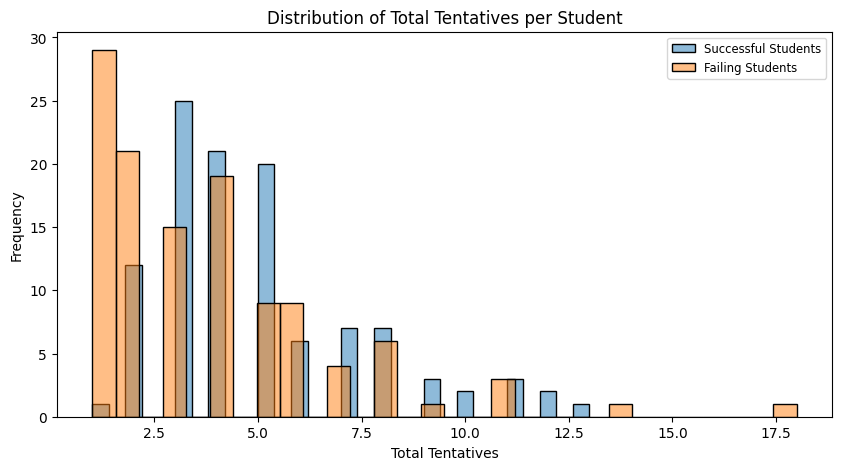

In [960]:
# Create histograms for the number of tentatives
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['nb_tentative'], bins=30, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['nb_tentative'], bins=30, label='Failing Students', alpha=0.5)
plt.xlabel('Total Tentatives')
plt.ylabel('Frequency')
plt.title('Distribution of Total Tentatives per Student')
plt.legend(fontsize='small')
plt.show()

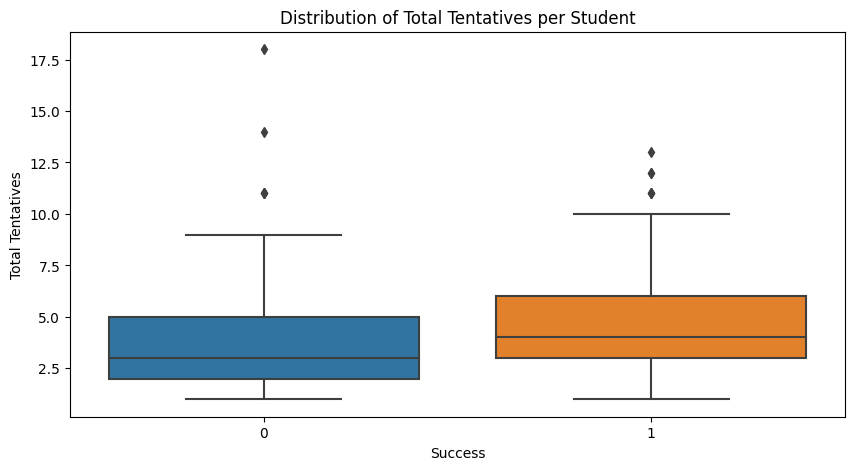

In [961]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='nb_tentative', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Total Tentatives')
plt.title('Distribution of Total Tentatives per Student')

plt.savefig(f"{folder}/boxplot_nb_tentatives_per_student.png")
plt.show()

In [962]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success['nb_tentative'], data_grouped_per_student_fail['nb_tentative'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)")


There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)


### Observe the number of errors per students 

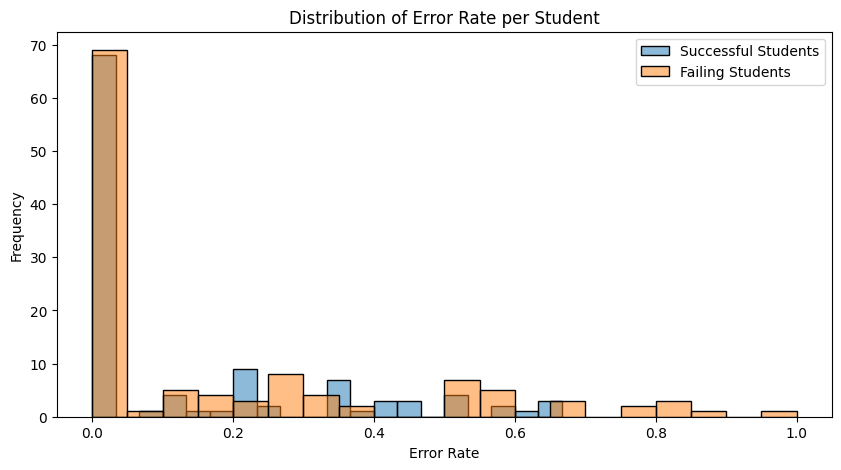

In [963]:
# plot distribution of percentage of error
plt.figure(figsize=(10, 5))

sns.histplot(data_grouped_per_student_success['pct_error'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['pct_error'], bins=20, label='Failing Students', alpha=0.5)
plt.xlabel('Error Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Error Rate per Student')
plt.legend()

plt.savefig(f"{folder}/error_rate_per_student.png")
plt.show()

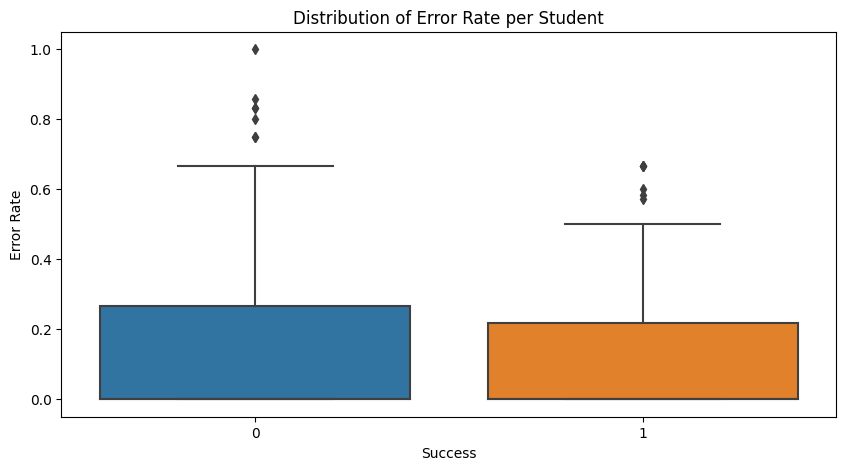

In [964]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='pct_error', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Error Rate')
plt.title('Distribution of Error Rate per Student')

plt.savefig(f"{folder}/boxplot_error_rate_per_student.png")
plt.show()

In [965]:
data_success_per_nb_tentative = data_success.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                          'pct_move1': ['mean', 'sem'], 'pct_move2': ['mean', 'sem'], 
                                                                          'pct_pickup1': ['mean', 'sem'], 'pct_place1': ['mean', 'sem']})
data_success_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

data_fail_per_nb_tentative = data_fail.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                    'pct_move1': ['mean', 'sem'], 'pct_move2': ['mean', 'sem'], 
                                                                    'pct_pickup1': ['mean', 'sem'], 'pct_place1': ['mean', 'sem']})
data_fail_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

# fill the NaN values with 0
data_success_per_nb_tentative = data_success_per_nb_tentative.fillna(0)
data_fail_per_nb_tentative = data_fail_per_nb_tentative.fillna(0)

In [966]:
nb_tentative_success = data_success_per_nb_tentative.index.to_list()
nb_tentative_fail = data_fail_per_nb_tentative.index.to_list()

nb_tentative_index = set(nb_tentative_success).intersection(set(nb_tentative_fail))

data_success_per_nb_tentative = data_success_per_nb_tentative[data_success_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()
data_fail_per_nb_tentative = data_fail_per_nb_tentative[data_fail_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()


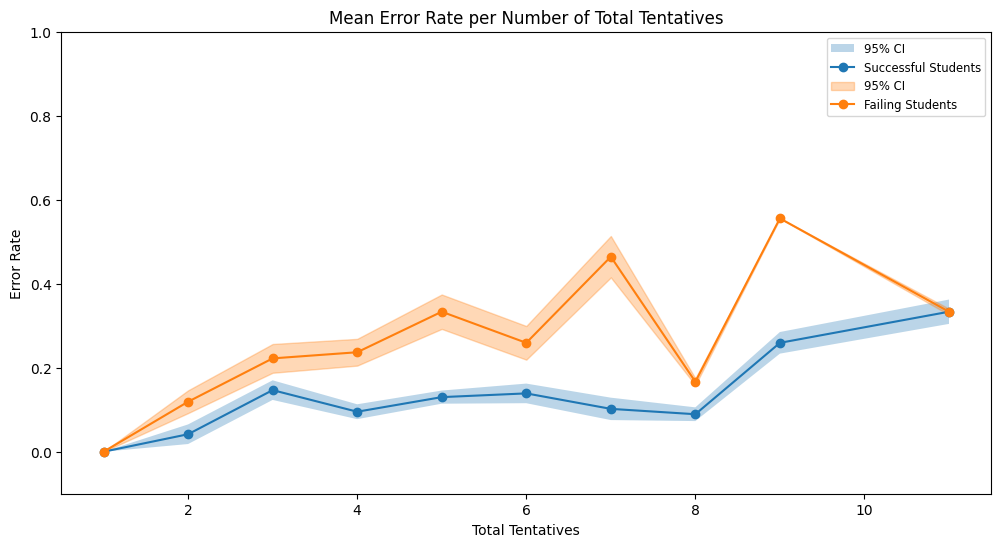

In [967]:
# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'] - data_success_per_nb_tentative['pct_error_sem'], 
                data_success_per_nb_tentative["pct_error_mean"] + data_success_per_nb_tentative['pct_error_sem'], alpha=0.3, label="95% CI")
ax.plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'], linestyle='-', marker='o', label='Successful Students')

ax.fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'] - data_fail_per_nb_tentative['pct_error_sem'], 
                data_fail_per_nb_tentative["pct_error_mean"] + data_fail_per_nb_tentative['pct_error_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'], color= '#ff7f0e', linestyle='-', marker='o', label="Failing Students")

# Set labels and title
ax.set_xlabel('Total Tentatives')
ax.set_ylabel('Error Rate')
ax.set_title('Mean Error Rate per Number of Total Tentatives')
ax.legend(fontsize='small')
plt.ylim(-0.1, 1)
plt.savefig(f"{folder}/error_rate_per_nb_tentatives.png")
plt.show()

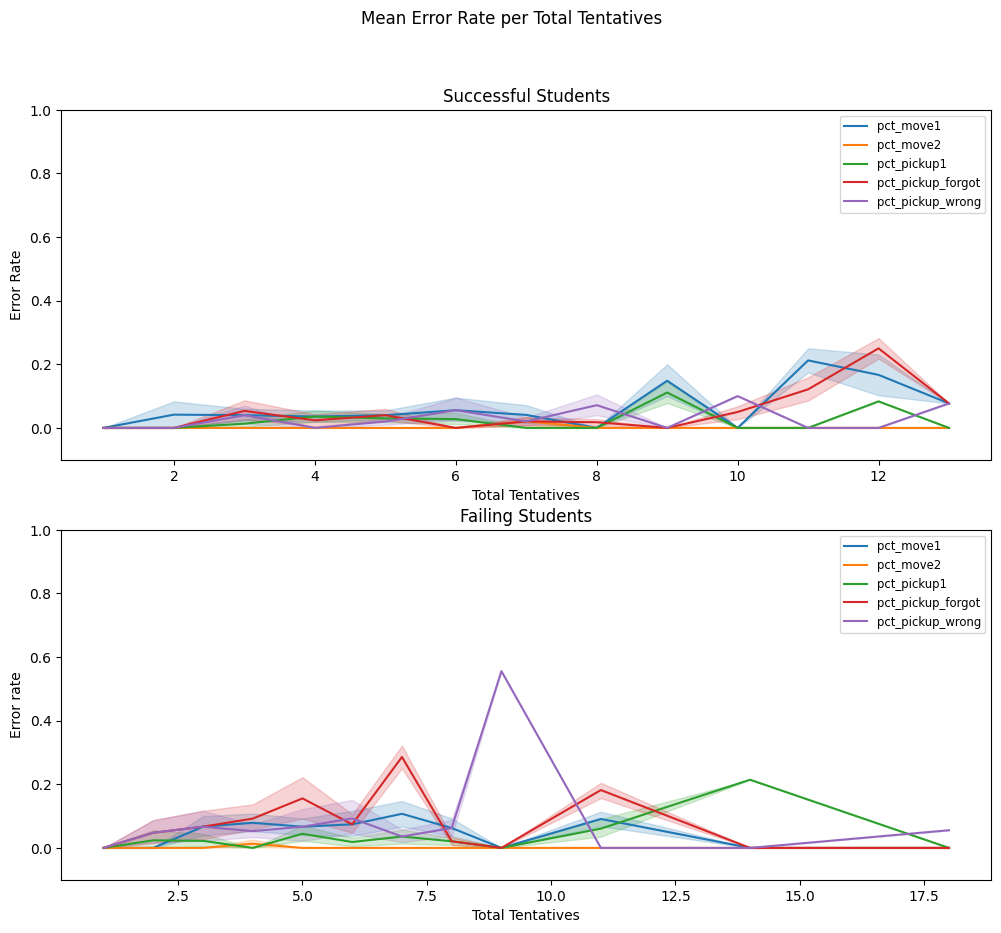

In [968]:
# plot the pct_error_move1, pct_error_move2, pct_error_pickup1, pct_error_pickup2 for Successful Students and Failing Students
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot change in Euclidean distance for successful students
for column in ['pct_move1', 'pct_move2', 'pct_pickup1', 'pct_pickup_forgot', 'pct_pickup_wrong']:
            sns.lineplot(data=data_success, y=column, x='nb_tentative', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax[0], label=column)

ax[0].set_ylim(-0.1, 1)
ax[0].set_xlabel('Total Tentatives')
ax[0].set_ylabel('Error Rate')
ax[0].set_title('Successful Students')
ax[0].legend(fontsize='small')

# Plot change in Euclidean distance for failing students
for column in ['pct_move1', 'pct_move2', 'pct_pickup1', 'pct_pickup_forgot', 'pct_pickup_wrong']:
            sns.lineplot(data=data_fail, y=column, x='nb_tentative', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax[1], label=column)
            
ax[1].set_ylim(-0.1, 1)
ax[1].set_xlabel('Total Tentatives')
ax[1].set_ylabel('Error rate')
ax[1].set_title('Failing Students')
ax[1].legend(fontsize='small')


plt.suptitle("Mean Error Rate per Total Tentatives")
plt.savefig(f"{folder}/type_error_rate_per_tentative.png")
plt.show()

In [969]:
# for each students, check what is the euclidean distance for the last tentative
data_tentative_7 = data_success[data_success['nb_tentative'] == 7]
data_last_tentative = data_tentative_7[data_tentative_7['index'] == data_tentative_7['nb_tentative']]
data_last_tentative[data_last_tentative['euclidean_distance'] != 0]


,Student ID,XML,WorldSpace,index,pickup_forgot,nb_tentative,pct_activity,error,missing,move1,...,pct_error,pct_missing,pct_move1,pct_move2,pct_pickup1,pct_place1,pct_pickup_forgot,pct_pickup_wrong,euclidean_distance,success


# Analysis of the difference between the successive runs

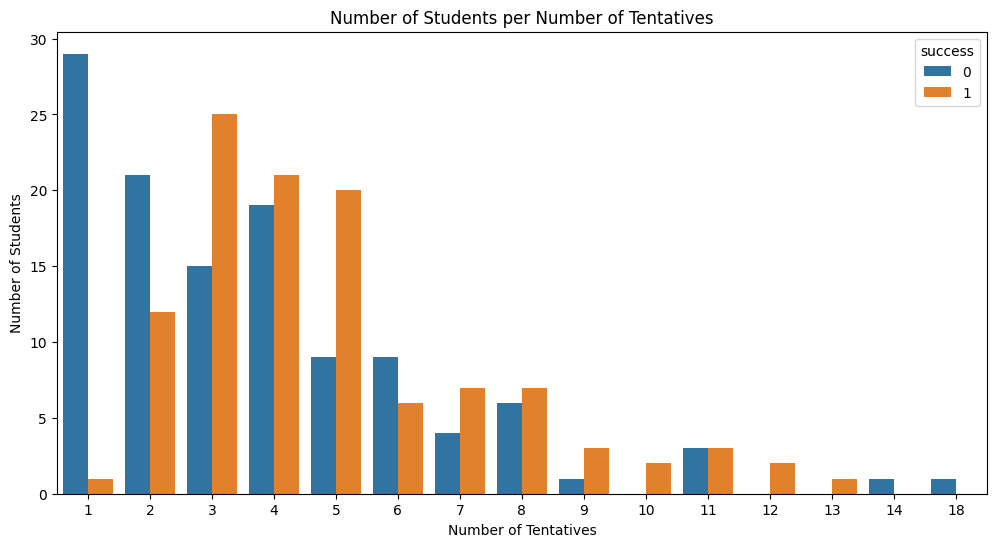

In [970]:
# bar plot of the number of students per number of tentatives
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x='nb_tentative', hue='success', data=data_grouped_per_student, ax=ax)

# add title and labels
ax.set_title('Number of Students per Number of Tentatives')
ax.set_xlabel('Number of Tentatives')
ax.set_ylabel('Number of Students')

plt.savefig(f'{folder}/students_per_tentatives.png')
plt.show()

Different type of errors: 
* move1 : cannot move, claw hit a wall 
* move 2 : collision, objects are stacked to high
* pickup1 : cannot pick up, claw is already holding an object 
* pickup2 : cannot place, claw is not holding any objet 

Should we differentiate the errors by giving a different penalty ? 

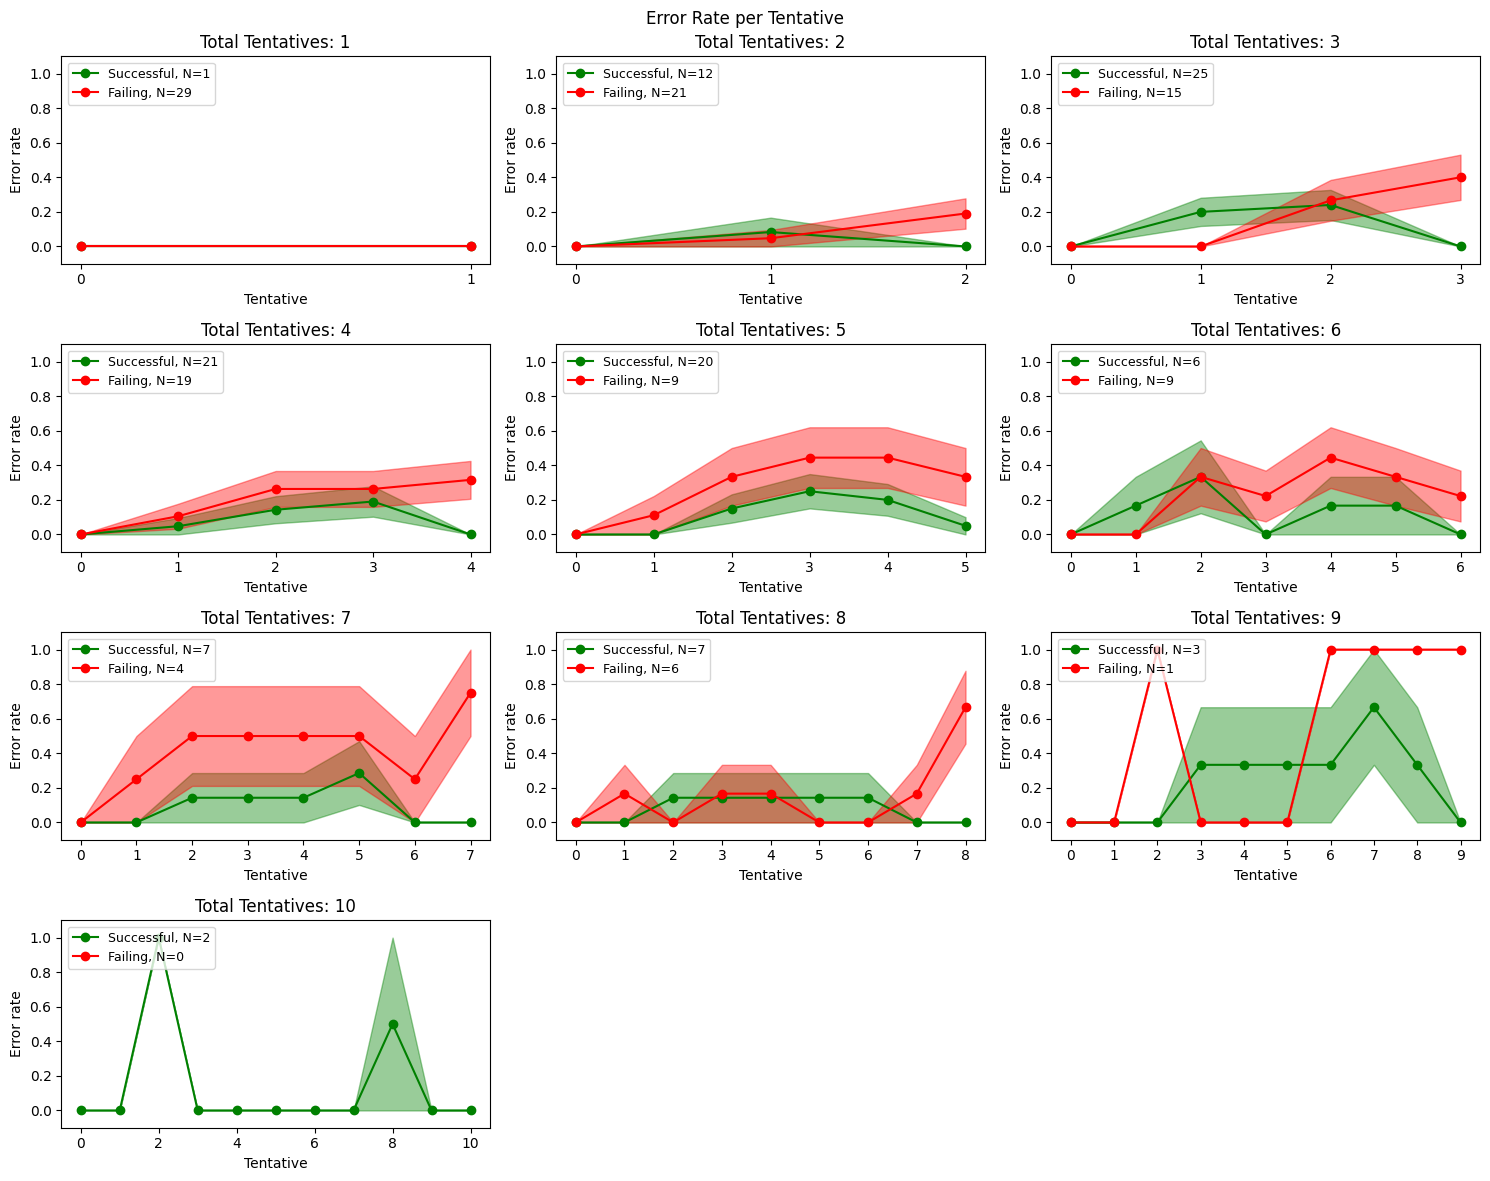

In [971]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success[data_success['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_success.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['error_sem'].fillna(0, inplace=True)

        grouped_fail = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_fail.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['error_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['error_mean'] - grouped_success['error_sem'], grouped_success["error_mean"] + grouped_success['error_sem'], alpha=0.4, color="green")
        ax.plot(grouped_success.index, grouped_success['error_mean'], linestyle='-', marker='o', label=f"Successful, N={nb_success_student}", color="green")
        
        ax.fill_between(grouped_fail.index, grouped_fail['error_mean'] - grouped_fail['error_sem'], grouped_fail["error_mean"] + grouped_fail['error_sem'], alpha=0.4, color="red")
        ax.plot(grouped_fail.index, grouped_fail['error_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}", color="red")
        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Error rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Error Rate per Tentative')
plt.tight_layout()
plt.savefig(f'{folder}/error_rate_multi.png')

plt.show()

## Error Analysis

Let's analysis what is the behavior of a student after an error 

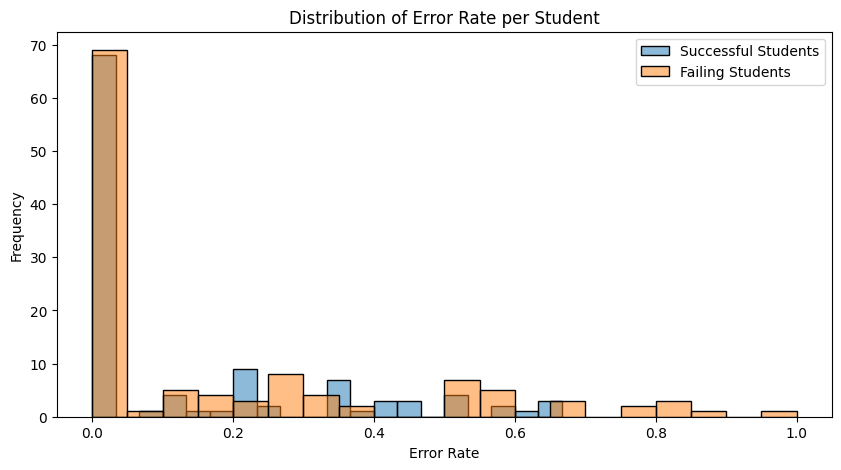

In [972]:
# plot distribution of error 
plt.figure(figsize=(10, 5))

sns.histplot(data_grouped_per_student_success['pct_error'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['pct_error'], bins=20, label='Failing Students', alpha=0.5)
plt.xlabel('Error Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Error Rate per Student')
plt.legend()
plt.savefig(f"{folder}/error_rate_hist_per_student.png")
plt.show()

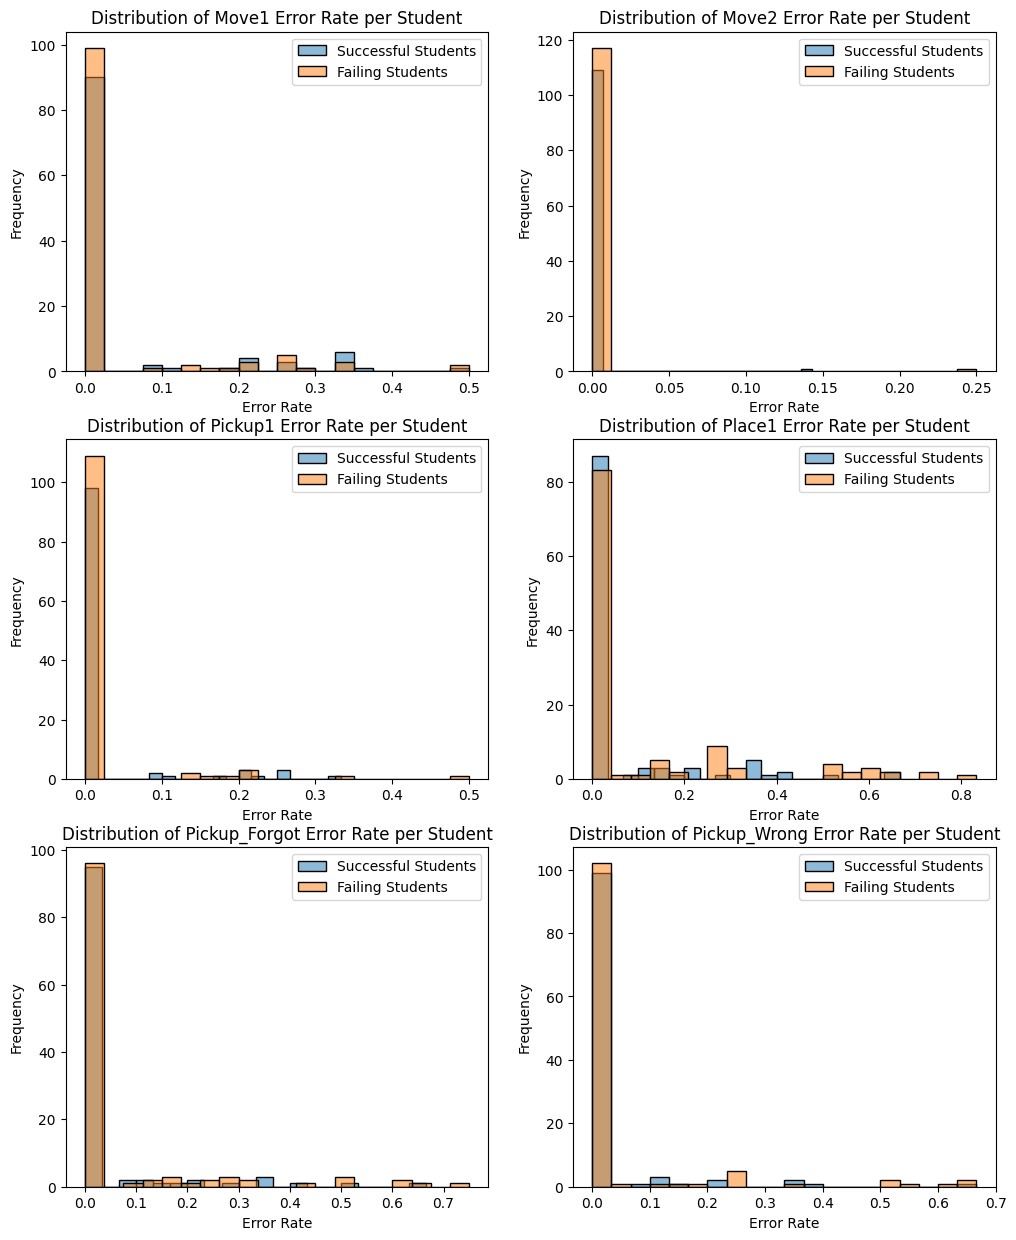

In [973]:
# plot 4 subplots for the percentage of error for each type of error
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

sns.histplot(data_grouped_per_student_success['pct_move1'], bins=20, label='Successful Students', alpha=0.5, ax=axs[0, 0])
sns.histplot(data_grouped_per_student_fail['pct_move1'], bins=20, label='Failing Students', alpha=0.5, ax=axs[0, 0])
axs[0, 0].set_xlabel('Error Rate')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Distribution of Move1 Error Rate per Student')
axs[0, 0].legend()

sns.histplot(data_grouped_per_student_success['pct_move2'], bins=20, label='Successful Students', alpha=0.5, ax=axs[0, 1])
sns.histplot(data_grouped_per_student_fail['pct_move2'], bins=20, label='Failing Students', alpha=0.5, ax=axs[0, 1])
axs[0, 1].set_xlabel('Error Rate')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Distribution of Move2 Error Rate per Student')
axs[0, 1].legend()

sns.histplot(data_grouped_per_student_success['pct_pickup1'], bins=20, label='Successful Students', alpha=0.5, ax=axs[1, 0])
sns.histplot(data_grouped_per_student_fail['pct_pickup1'], bins=20, label='Failing Students', alpha=0.5, ax=axs[1, 0])
axs[1, 0].set_xlabel('Error Rate')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Distribution of Pickup1 Error Rate per Student')
axs[1, 0].legend()

sns.histplot(data_grouped_per_student_success['pct_place1'], bins=20, label='Successful Students', alpha=0.5, ax=axs[1, 1])
sns.histplot(data_grouped_per_student_fail['pct_place1'], bins=20, label='Failing Students', alpha=0.5, ax=axs[1, 1])
axs[1, 1].set_xlabel('Error Rate')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Place1 Error Rate per Student')
axs[1, 1].legend()

sns.histplot(data_grouped_per_student_success['pct_pickup_forgot'], bins=20, label='Successful Students', alpha=0.5, ax=axs[2, 0])
sns.histplot(data_grouped_per_student_fail['pct_pickup_forgot'], bins=20, label='Failing Students', alpha=0.5, ax=axs[2, 0])
axs[2, 0].set_xlabel('Error Rate')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_title('Distribution of Pickup_Forgot Error Rate per Student')
axs[2, 0].legend()

sns.histplot(data_grouped_per_student_success['pct_pickup_wrong'], bins=20, label='Successful Students', alpha=0.5, ax=axs[2, 1])
sns.histplot(data_grouped_per_student_fail['pct_pickup_wrong'], bins=20, label='Failing Students', alpha=0.5, ax=axs[2, 1])
axs[2, 1].set_xlabel('Error Rate')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_title('Distribution of Pickup_Wrong Error Rate per Student')
axs[2, 1].legend()

plt.savefig(f"{folder}/error_rate_type_per_student.png")
plt.show()

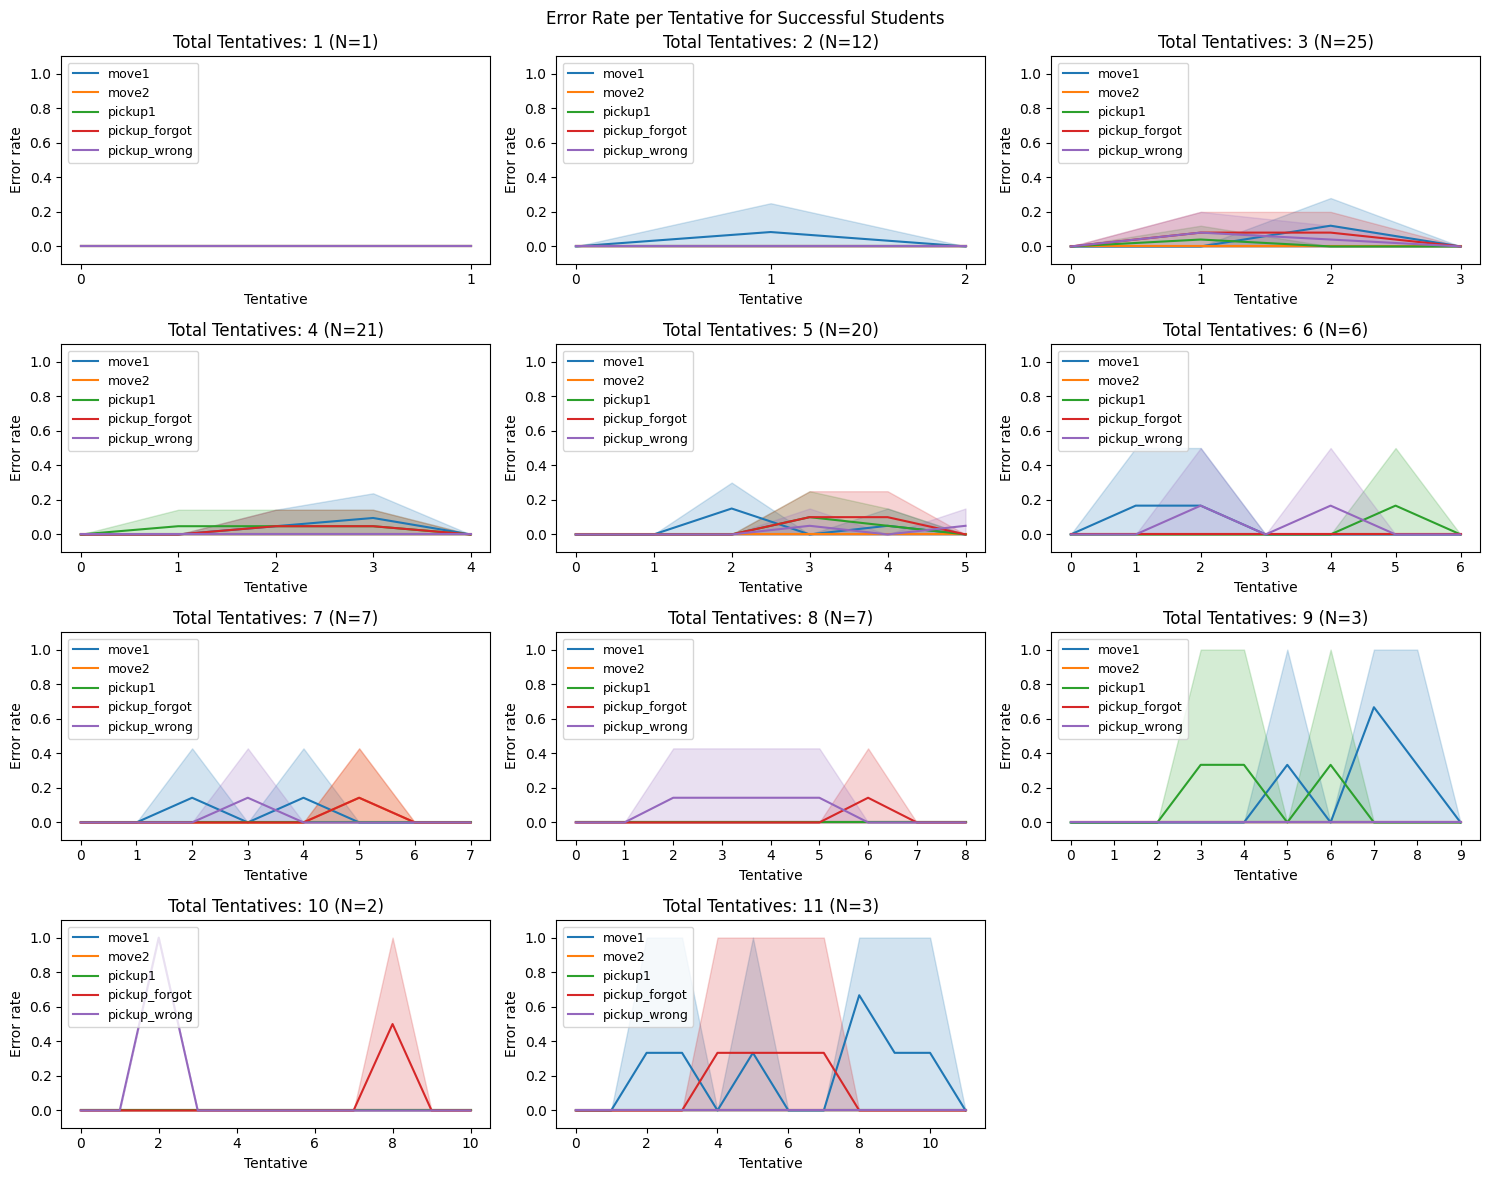

In [974]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        data_success_tentative = data_success[data_success['nb_tentative'] == tot_tentatives[i]]

        nb_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        
        for column in ['move1', 'move2', 'pickup1', 'pickup_forgot', 'pickup_wrong']:
            sns.lineplot(data=data_success_tentative, y=column, x='index', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax, label=column)


        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]} (N={nb_student})")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Error rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Error Rate per Tentative for Successful Students')
plt.tight_layout()
plt.savefig(f'{folder}/error_rate_successful_muli.png')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


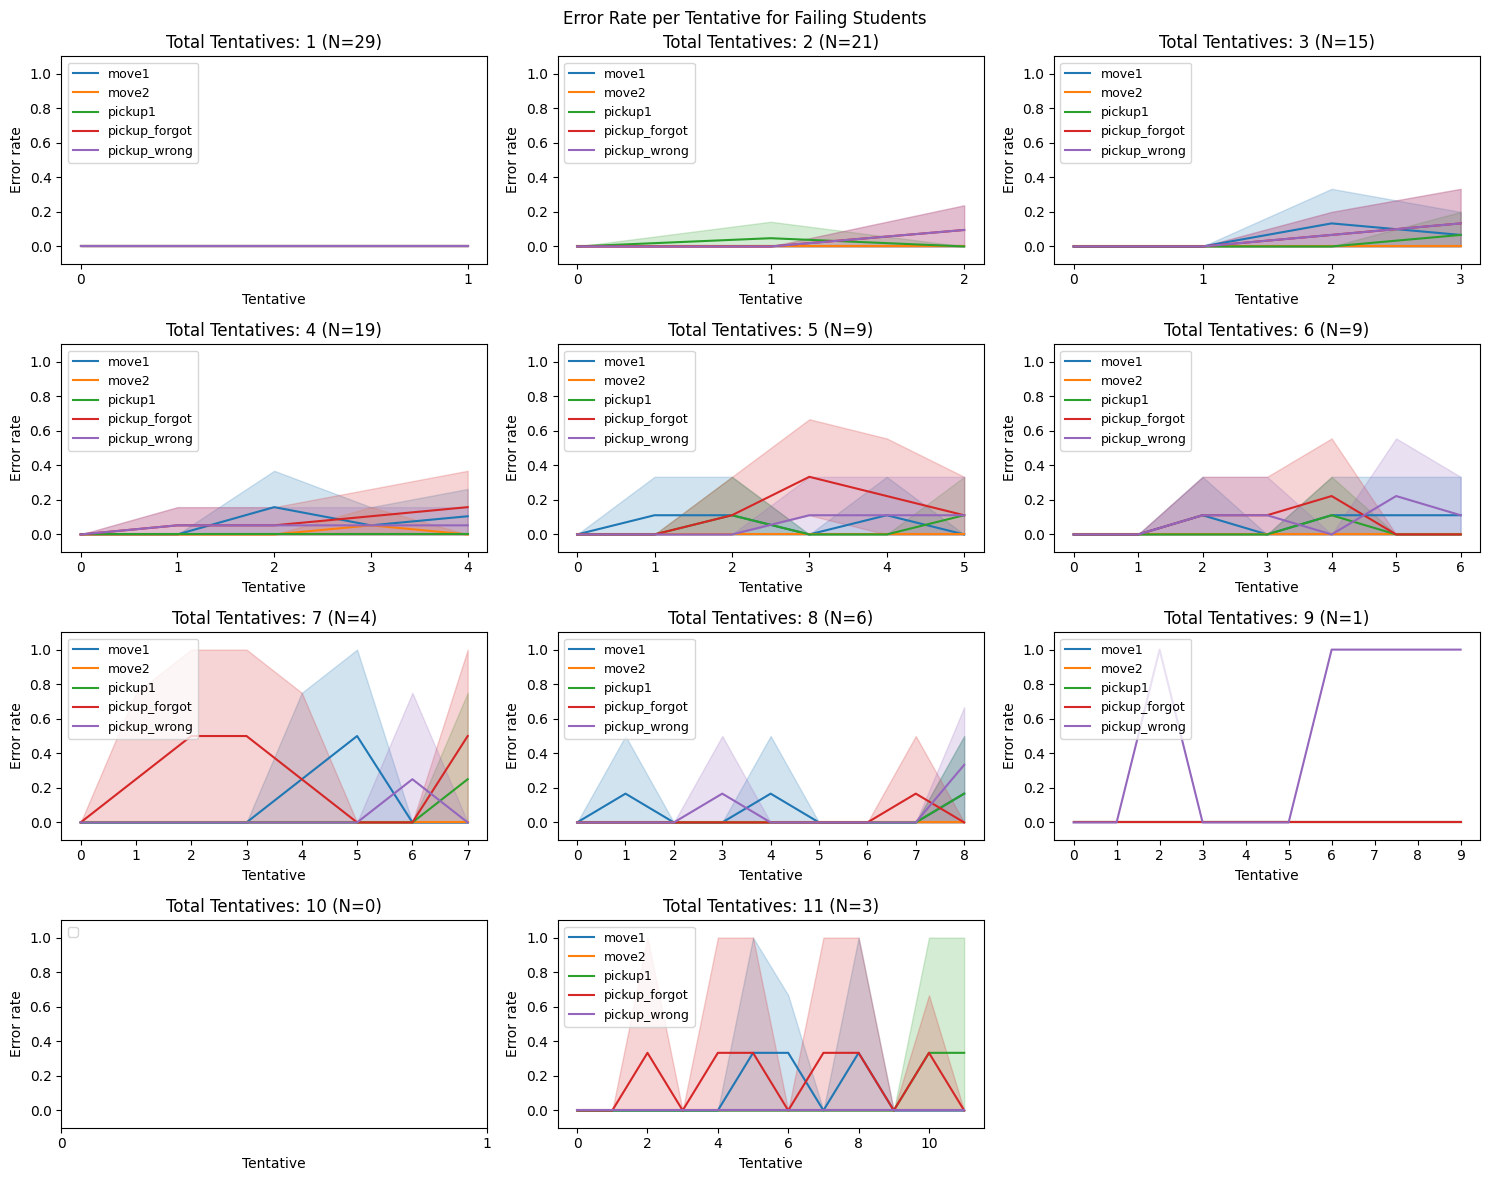

In [975]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        data_fail_tentative = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]

        nb_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        
        for column in ['move1', 'move2', 'pickup1', 'pickup_forgot', 'pickup_wrong']:
            sns.lineplot(data=data_fail_tentative, y=column, x='index', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax, label=column)


        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]} (N={nb_student})")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Error rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Error Rate per Tentative for Failing Students')
plt.tight_layout()
plt.savefig(f'{folder}/error_rate_failing_multi.png')

plt.show()

In [976]:
grouped = data.groupby('Student ID')

def filter_rows(group):
    first_error_index = group[group['error'] ==  1].index.min()
    if pd.isnull(first_error_index):  # If no error occurred, return an empty DataFrame
        return pd.DataFrame()
    else:
        return group.loc[first_error_index:]

data_error = pd.concat([filter_rows(group) for _, group in grouped])
data_error = data_error.reset_index(drop=True)


In [977]:
data_error_tentatives = []

for i in range(1, 13):
    data_error_tentatives.append(data_error.groupby('Student ID').nth(i))

In [978]:
data_error_rate_success = []
data_error_rate_fail = []

for df in data_error_tentatives:
    df_success = df[df['success'] == 1]
    
    error_rate = df_success['error'].mean()
    non_error_rate = 1 - error_rate
    move1_rate = df_success['move1'].mean()
    move2_rate = df_success['move2'].mean()
    pickup1_rate = df_success['pickup1'].mean()
    #place1_rate = df_success['place1'].mean()
    pickup_forgot_rate = df_success['pickup_forgot'].mean()
    pickup_wrong_rate = df_success['pickup_wrong'].mean()
    
    data_error_rate_success.append({'error_rate': error_rate, 'non_error_rate': non_error_rate, 
                                    'move1_rate': move1_rate, 'move2_rate': move2_rate, 'pickup_forgot_rate': pickup_forgot_rate, 
                                    'pickup_wrong_rate': pickup_wrong_rate, 'pickup1_rate': pickup1_rate, 'count': len(df_success)})
    
for df in data_error_tentatives:
    df_fail = df[df['success'] == 0]
    
    error_rate = df_fail['error'].mean()
    non_error_rate = 1 - error_rate
    move1_rate = df_fail['move1'].mean()
    move2_rate = df_fail['move2'].mean()
    pickup1_rate = df_fail['pickup1'].mean()
    #place1_rate = df_fail['place1'].mean()
    pickup_forgot_rate = df_fail['pickup_forgot'].mean()
    pickup_wrong_rate = df_fail['pickup_wrong'].mean()
    
    data_error_rate_fail.append({'error_rate': error_rate, 'non_error_rate': non_error_rate,
                                    'move1_rate': move1_rate, 'move2_rate': move2_rate, 'pickup_forgot_rate': pickup_forgot_rate, 
                                    'pickup_wrong_rate': pickup_wrong_rate, 
                                    'pickup1_rate': pickup1_rate, 'count': len(df_fail)})
    

In [979]:
data_error_rate_success = pd.DataFrame(data_error_rate_success)
data_error_rate_fail = pd.DataFrame(data_error_rate_fail)

In [980]:
# add column tentatives to the data_error_rate_success and data_error_rate_fail
data_error_rate_success['tentatives'] = [f"t+{i}" for i in range(1, 13)]
data_error_rate_fail['tentatives'] = [f"t+{i}" for i in range(1, 13)]

In [981]:
data_error_rate_success

,error_rate,non_error_rate,move1_rate,move2_rate,pickup_forgot_rate,pickup_wrong_rate,pickup1_rate,count,tentatives
0,0.404762,0.595238,0.119048,0.000000,0.119048,0.095238,0.071429,42,t+1
1,0.272727,0.727273,0.060606,0.000000,0.121212,0.090909,0.000000,33,t+2
2,0.263158,0.736842,0.105263,0.052632,0.105263,0.000000,0.000000,19,t+3
3,0.307692,0.692308,0.153846,0.000000,0.153846,0.000000,0.000000,13,t+4
4,0.181818,0.818182,0.181818,0.000000,0.000000,0.000000,0.000000,11,t+5
5,0.222222,0.777778,0.111111,0.000000,0.111111,0.000000,0.000000,9,t+6
6,0.166667,0.833333,0.000000,0.000000,0.166667,0.000000,0.000000,6,t+7
7,0.166667,0.833333,0.000000,0.000000,0.000000,0.166667,0.000000,6,t+8
8,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.333333,3,t+9
9,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,t+10


In [982]:
data_error_rate_fail.columns

Index(['error_rate', 'non_error_rate', 'move1_rate', 'move2_rate',
       'pickup_forgot_rate', 'pickup_wrong_rate', 'pickup1_rate', 'count',
       'tentatives'],
      dtype='object')

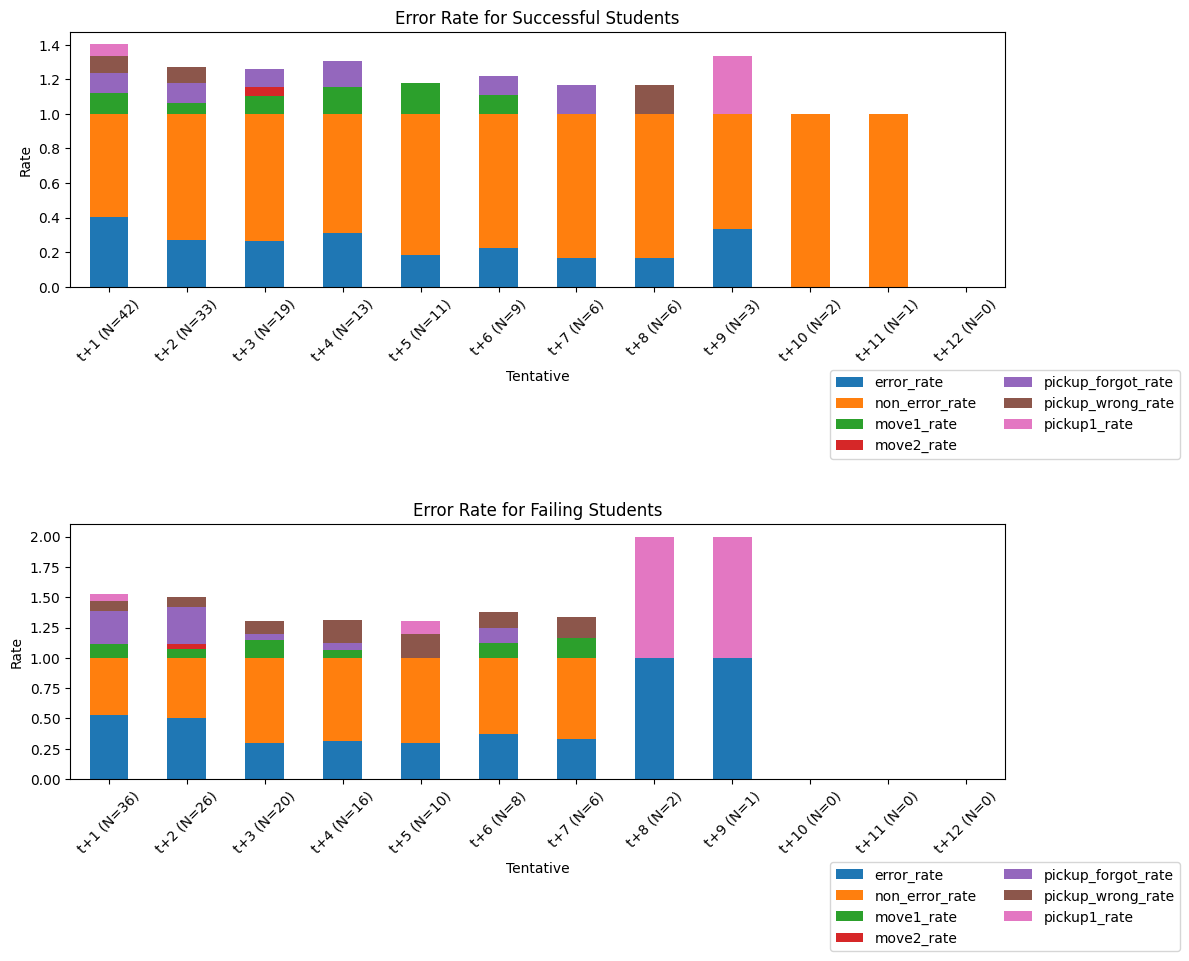

In [983]:
# create two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 20))

tentatives_success = [f"{tentative} (N={count})" for tentative, count in zip(data_error_rate_success['tentatives'], data_error_rate_success['count'])]
tentatives_fail = [f"{tentative} (N={count})" for tentative, count in zip(data_error_rate_fail['tentatives'], data_error_rate_fail['count'])]

data_error_rate_success['tentatives'] = tentatives_success
data_error_rate_fail['tentatives'] = tentatives_fail

# Loop through each column and plot it as a stacked bar
data_error_rate_success[['error_rate', 'non_error_rate', 'move1_rate', 'move2_rate',
       'pickup_forgot_rate', 'pickup_wrong_rate', 'pickup1_rate', 'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), ax=ax[0], x='tentatives', legend=False)

ax[0].set_title('Error Rate for Successful Students')
ax[0].set_xlabel('Tentative')
ax[0].set_ylabel('Rate')
ax[0].legend(loc='upper center', bbox_to_anchor=(1, -0.3), fancybox=True, ncol=2)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

data_error_rate_fail[['error_rate', 'non_error_rate', 'move1_rate', 'move2_rate',
         'pickup_forgot_rate', 'pickup_wrong_rate', 'pickup1_rate', 'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), ax=ax[1], x='tentatives')

ax[1].set_title('Error Rate for Failing Students')
ax[1].set_xlabel('Tentative')
ax[1].set_ylabel('Rate')
ax[1].legend(loc='upper center', bbox_to_anchor=(1, -0.3), fancybox=True, ncol=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(f"{folder}/error_rate_type_bar.png")
plt.show()

Let's analyse it per tentative

In [984]:
def filter_rows(group):
    first_error_index = group[group['error'] ==  1].index.min()
    if pd.isnull(first_error_index):  # If no error occurred, return an empty DataFrame
        return pd.DataFrame()
    else:
        return group.loc[first_error_index:]

grouped = data.groupby('Student ID')

data_error = pd.concat([filter_rows(group) for _, group in grouped])
data_error = data_error.reset_index(drop=True)

In [985]:
def generate_data_all_errors(data, tentative): 
    print(f"Generate data for {tentative} tentatives")
    data_error_same_diff_tentatives = []

    for i in range(1, tentative):
        data_error_same_diff_tentatives.append(data.groupby('Student ID').nth(i))
        
    data_error_success = []
    data_error_fail = []

    for df in data_error_same_diff_tentatives:
        df_success = df[df['success'] == 1]
        
        error_rate = df_success['error'].mean()
        no_error_rate = 1 - error_rate
        move1_rate = df_success['move1'].mean()
        move2_rate = df_success['move2'].mean()
        pickup1_rate = df_success['pickup1'].mean()
        pickup_forgot_rate = df_success['pickup_forgot'].mean()
        pickup_wrong_rate = df_success['pickup_wrong'].mean()
        
        data_error_success.append({'error_rate': error_rate, 'no_error_rate': no_error_rate, 'move1_rate': move1_rate, 
                                        'move2_rate': move2_rate, 'pickup1_rate': pickup1_rate, 'pickup_forgot_rate': pickup_forgot_rate,
                                        'pickup_wrong_rate': pickup_wrong_rate, 'count': len(df_success), 'nb_tentatives': tentative, 'success': 1})
        
        df_fail = df[df['success'] == 0]
        
        error_rate = df_fail['error'].mean()
        no_error_rate = 1 - error_rate
        move1_rate = df_fail['move1'].mean()
        move2_rate = df_fail['move2'].mean()
        pickup1_rate = df_fail['pickup1'].mean()
        pickup_forgot_rate = df_fail['pickup_forgot'].mean()
        pickup_wrong_rate = df_fail['pickup_wrong'].mean()
        
        data_error_fail.append({'error_rate': error_rate, 'no_error_rate': no_error_rate, 'move1_rate': move1_rate,
                                    'move2_rate': move2_rate, 'pickup1_rate': pickup1_rate, 'pickup_forgot_rate': pickup_forgot_rate, 
                                    'pickup_wrong_rate': pickup_wrong_rate, 'count': len(df_fail), 'nb_tentatives': tentative, 'success': 0})
        
    data_error_success = pd.DataFrame(data_error_success)
    data_error_fail = pd.DataFrame(data_error_fail)

    # add column tentatives to the data_error_rate_success and data_error_rate_fail
    data_error_success['tentatives'] = [f"t+{i}" for i in range(1, tentative)]
    data_error_fail['tentatives'] = [f"t+{i}" for i in range(1, tentative)]

    tentatives_success = [f"{tentative} (N={count})" for tentative, count in zip(data_error_success['tentatives'], data_error_success['count'])]
    tentatives_fail = [f"{tentative} (N={count})" for tentative, count in zip(data_error_fail['tentatives'], data_error_fail['count'])]

    data_error_success['tentatives'] = tentatives_success
    data_error_fail['tentatives'] = tentatives_fail
    
    data_same_diff = pd.concat([data_error_success, data_error_fail])
    
    return data_same_diff

In [986]:
data_error_filtered = data_error[data_error['nb_tentative'] <= 12]

data_tentatives_error = []

for i in range(2, data_error_filtered['nb_tentative'].max()+1):
    df = data_error_filtered[data_error_filtered['nb_tentative'] == i]
    print(len(df))
    data_tentatives_error.append(generate_data_all_errors(df, i))


8
Generate data for 2 tentatives
32
Generate data for 3 tentatives
37
Generate data for 4 tentatives
47
Generate data for 5 tentatives
36
Generate data for 6 tentatives
28
Generate data for 7 tentatives
37
Generate data for 8 tentatives
23
Generate data for 9 tentatives
18
Generate data for 10 tentatives
46
Generate data for 11 tentatives
20
Generate data for 12 tentatives


In [987]:
data_tentatives_error = pd.concat(data_tentatives_error)

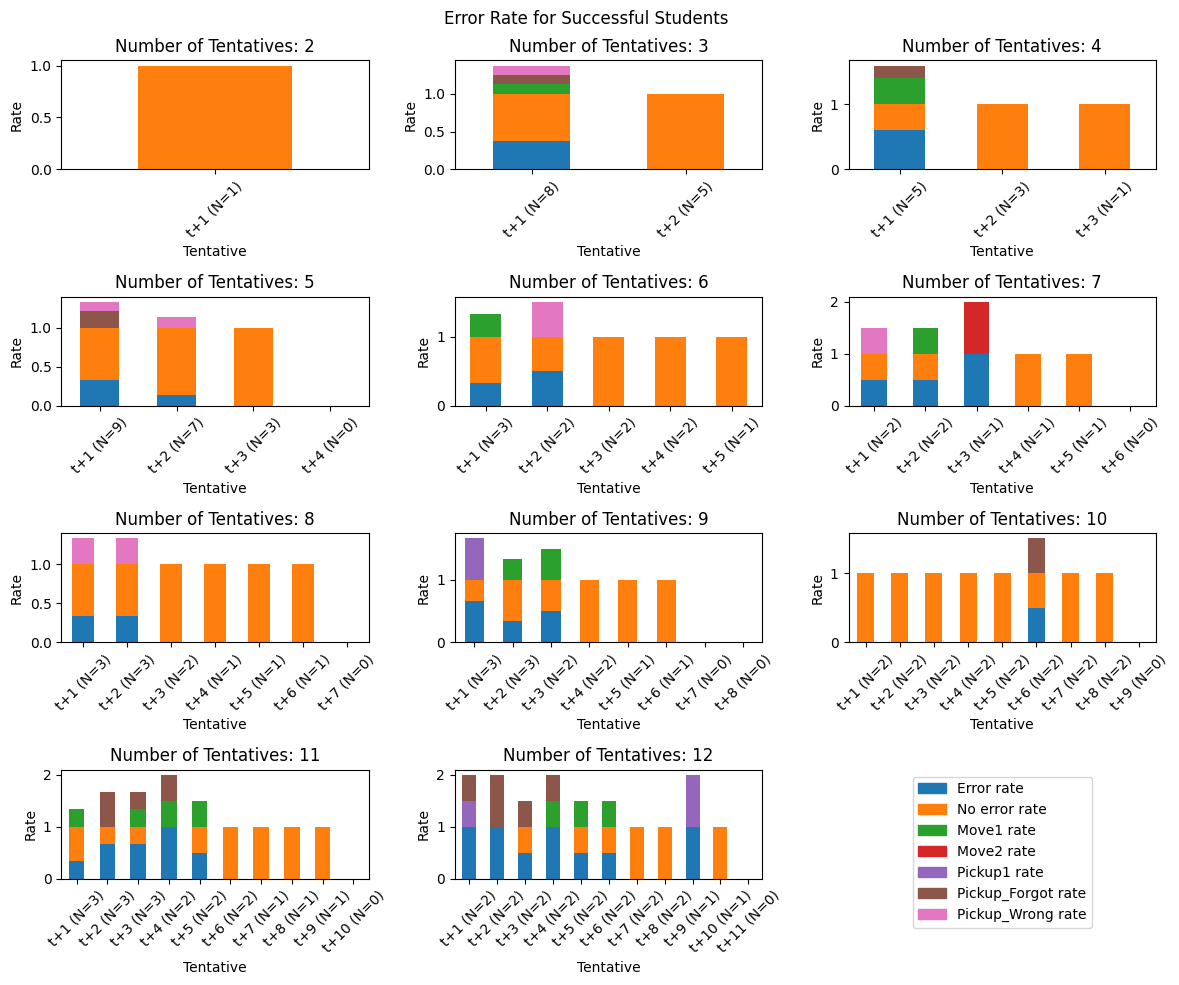

In [988]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(data_tentatives_error['nb_tentatives'].unique()):
        df = data_tentatives_error[data_tentatives_error['nb_tentatives'] == i+2]
        df_success = df[df['success'] == 1]
        
        df_success[['error_rate', 'no_error_rate', 'move1_rate', 'move2_rate', 'pickup1_rate', 'pickup_forgot_rate', 'pickup_wrong_rate', 'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), x='tentatives', legend=False, ax=ax)
        ax.set_title(f"Number of Tentatives: {i+2}")
        ax.set_xlabel('Tentative')
        ax.set_ylabel('Rate')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    else:
        ax.axis('off')
    
legend_patches = [mpatches.Patch(color='tab:blue', label='Error rate'), 
                  mpatches.Patch(color='tab:orange', label='No error rate'), 
                  mpatches.Patch(color='tab:green', label='Move1 rate'), 
                  mpatches.Patch(color='tab:red', label='Move2 rate'),
                  mpatches.Patch(color='tab:purple', label='Pickup1 rate'),
                  mpatches.Patch(color='tab:brown', label='Pickup_Forgot rate'),
                  mpatches.Patch(color='tab:pink', label='Pickup_Wrong rate')] 
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1), fancybox=True, ncol=1)
plt.suptitle('Error Rate for Successful Students')
plt.tight_layout()
plt.savefig(f"{folder}/error_rate_type_per_tentative_success_multi.png")
plt.show()

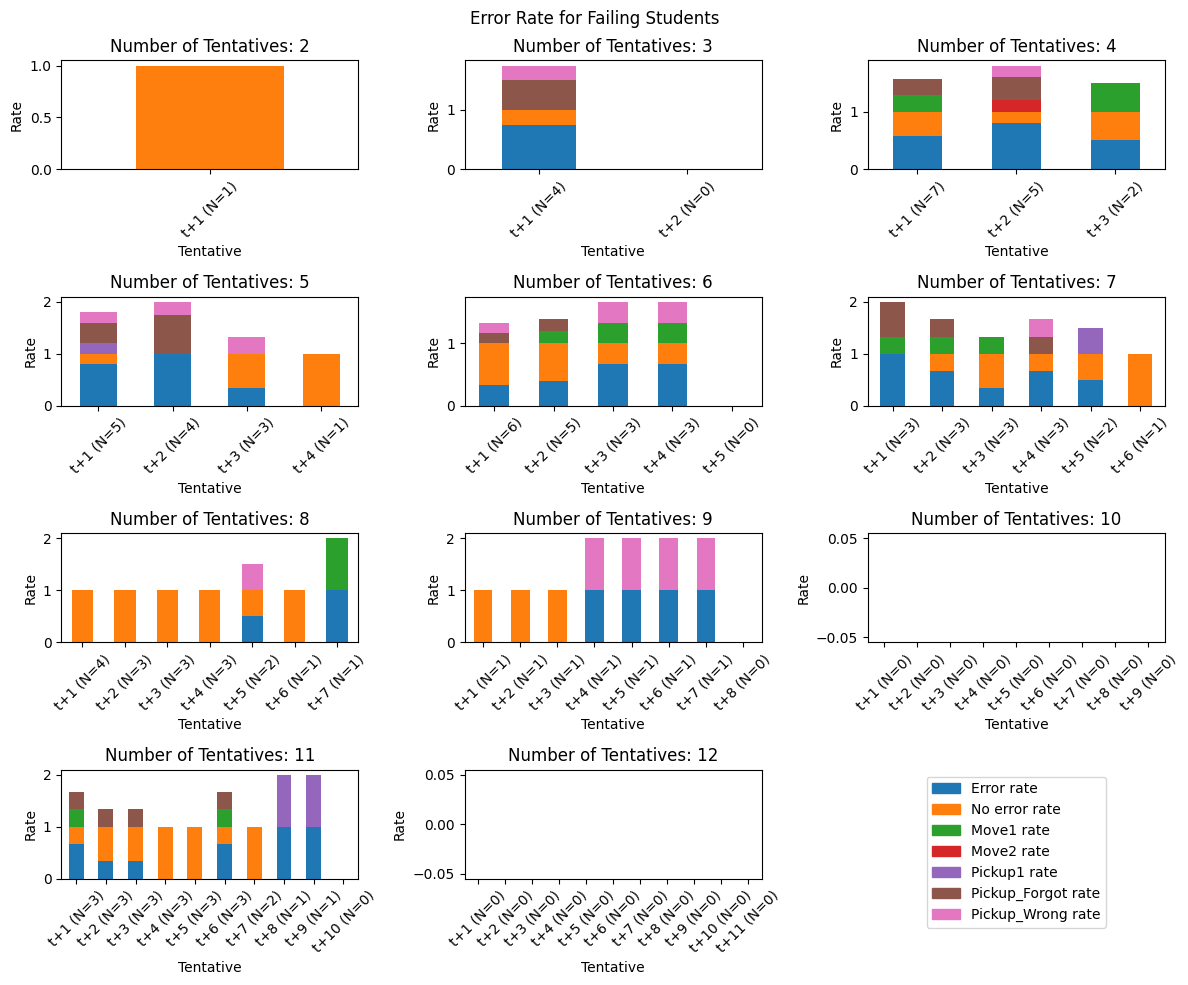

In [989]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(data_tentatives_error['nb_tentatives'].unique()):
        df = data_tentatives_error[data_tentatives_error['nb_tentatives'] == i+2]
        df_fail = df[df['success'] == 0]
        
        df_fail[['error_rate', 'no_error_rate', 'move1_rate', 'move2_rate', 'pickup1_rate', 'pickup_forgot_rate', 'pickup_wrong_rate', 'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), x='tentatives', legend=False, ax=ax)
        ax.set_title(f"Number of Tentatives: {i+2}")
        ax.set_xlabel('Tentative')
        ax.set_ylabel('Rate')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    else:
        ax.axis('off')
    
legend_patches = [mpatches.Patch(color='tab:blue', label='Error rate'), 
                  mpatches.Patch(color='tab:orange', label='No error rate'), 
                  mpatches.Patch(color='tab:green', label='Move1 rate'), 
                  mpatches.Patch(color='tab:red', label='Move2 rate'),
                  mpatches.Patch(color='tab:purple', label='Pickup1 rate'),
                  mpatches.Patch(color='tab:brown', label='Pickup_Forgot rate'),
                  mpatches.Patch(color='tab:pink', label='Pickup_Wrong rate')] 
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1), fancybox=True, ncol=1)
plt.suptitle('Error Rate for Failing Students')
plt.tight_layout()
plt.savefig(f"{folder}/error_rate_type_per_tentative_fail_multi.png")
plt.show()

Let's see now the percentage of students doing the same error at the next step, of doing another error, and not doing an error : 

In [990]:
def same_error_evaluation(move1_1, move2_1, place1_1, pickup1_1, move1_2, move2_2, place1_2, pickup1_2):
    if move1_1 == move1_2 and move2_1 == move2_2 and place1_1 == place1_2 and pickup1_1 == pickup1_2:
        return 1
    else:
        return 0

In [991]:
# group by Student ID and add column "same_error" if the error is the same as the previous tentative, else "different_error" if the error is different or "no_error" if there is no error
data_student = data.groupby('Student ID')

data_error_same_diff = pd.DataFrame()
index = 0

for student_id, group in data_student:
    group = group.reset_index(drop=True)
    index += 1
    for idx, row in group.iterrows():
        if idx == 0:
            group.loc[idx, 'same_error'] = 0
            group.loc[idx, 'diff_error'] = 0
            group.loc[idx, 'no_error'] = 0
        else:
            if row['error'] == 0:
                group.loc[idx, 'same_error'] = 0
                group.loc[idx, 'diff_error'] = 0
                group.loc[idx, 'no_error'] = 1
            else:
                same_error = same_error_evaluation(group.loc[idx-1, 'move1'], group.loc[idx-1, 'move2'], group.loc[idx-1, 'place1'], group.loc[idx-1, 'pickup1'], 
                                                   row['move1'], row['move2'], row['place1'], row['pickup1'])
                group.loc[idx, 'same_error'] = same_error
                group.loc[idx, 'diff_error'] = 1 - same_error
                group.loc[idx, 'no_error'] = 0
                
    data_error_same_diff = pd.concat([data_error_same_diff, group])

In [992]:
grouped = data_error_same_diff.groupby('Student ID')

def filter_rows(group):
    first_error_index = group[group['error'] ==  1].index.min()
    if pd.isnull(first_error_index):  # If no error occurred, return an empty DataFrame
        return pd.DataFrame()
    else:
        return group.loc[first_error_index:]

data_error_same_diff = pd.concat([filter_rows(group) for _, group in grouped])
data_error_same_diff = data_error_same_diff.reset_index(drop=True)

In [993]:
data_error_same_diff_tentatives = []

for i in range(1, 13):
    data_error_same_diff_tentatives.append(data_error_same_diff.groupby('Student ID').nth(i))

In [994]:
data_same_diff_success = []
data_same_diff_fail = []

for df in data_error_same_diff_tentatives:
    df_success = df[df['success'] == 1]
    
    same_error_rate = df_success['same_error'].mean()
    diff_error_rate = df_success['diff_error'].mean()
    no_error_rate = df_success['no_error'].mean()
    
    data_same_diff_success.append({'same_error_rate': same_error_rate, 'diff_error_rate': diff_error_rate, 
                                    'no_error_rate': no_error_rate, 'count': len(df_success)})
    
for df in data_error_same_diff_tentatives:
    df_fail = df[df['success'] == 0]
    
    same_error_rate = df_fail['same_error'].mean()
    diff_error_rate = df_fail['diff_error'].mean()
    no_error_rate = df_fail['no_error'].mean()
    
    data_same_diff_fail.append({'same_error_rate': same_error_rate, 'diff_error_rate': diff_error_rate, 
                                    'no_error_rate': no_error_rate, 'count': len(df_fail)})
    

In [995]:
data_same_diff_success = pd.DataFrame(data_same_diff_success)
data_same_diff_fail = pd.DataFrame(data_same_diff_fail)

# add column tentatives to the data_error_rate_success and data_error_rate_fail
data_same_diff_success['tentatives'] = [f"t+{i}" for i in range(1, 13)]
data_same_diff_fail['tentatives'] = [f"t+{i}" for i in range(1, 13)]

tentatives_success = [f"{tentative} (N={count})" for tentative, count in zip(data_same_diff_success['tentatives'], data_same_diff_success['count'])]
tentatives_fail = [f"{tentative} (N={count})" for tentative, count in zip(data_same_diff_fail['tentatives'], data_same_diff_fail['count'])]

data_same_diff_success['tentatives'] = tentatives_success
data_same_diff_fail['tentatives'] = tentatives_fail

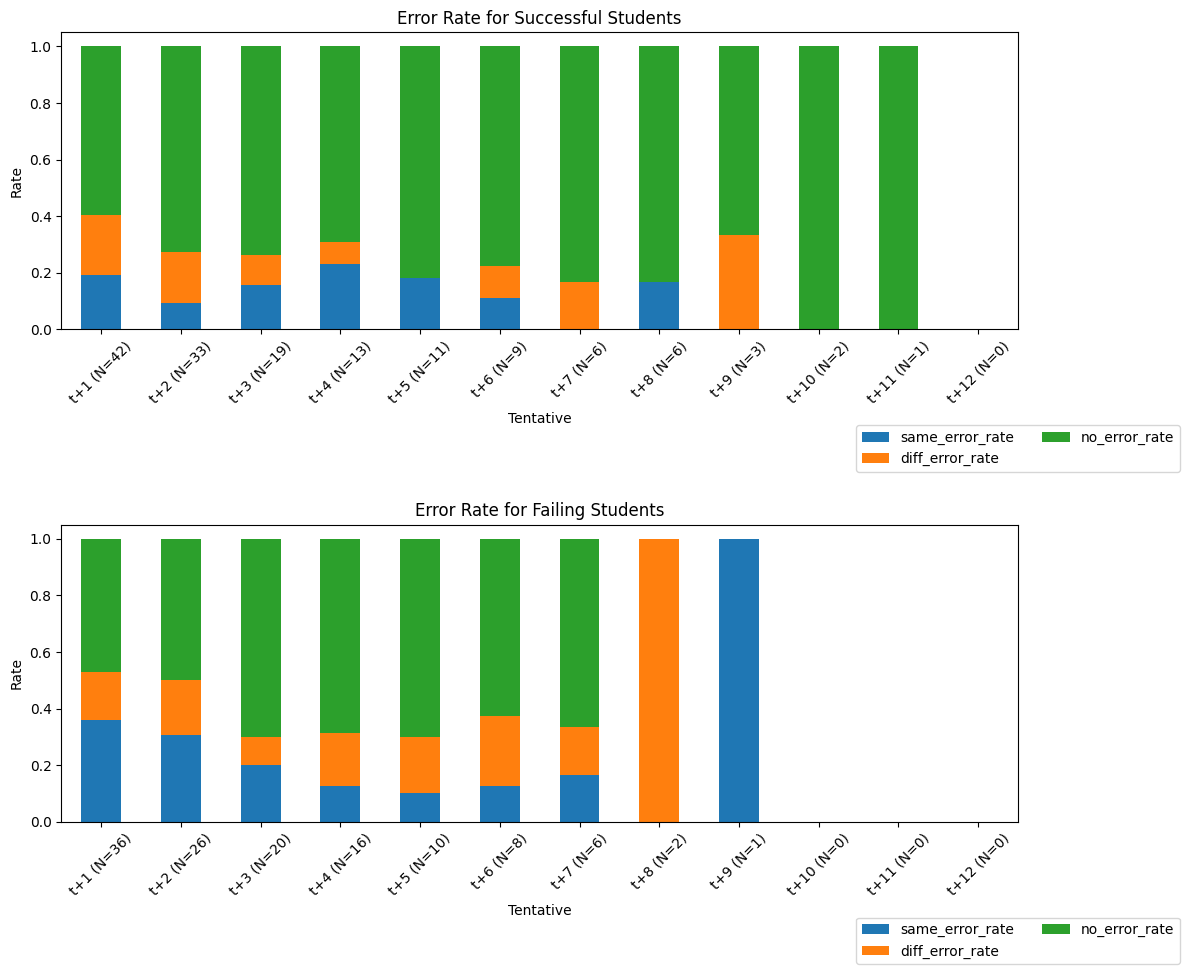

In [996]:
# create two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 20))

# Loop through each column and plot it as a stacked bar
bars = data_same_diff_success[['same_error_rate', 'diff_error_rate', 'no_error_rate',
       'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), ax=ax[0], x='tentatives', legend=False)

ax[0].set_title('Error Rate for Successful Students')
ax[0].set_xlabel('Tentative')
ax[0].set_ylabel('Rate')
ax[0].legend(loc='upper center', bbox_to_anchor=(1, -0.3), fancybox=True, ncol=2)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)


data_same_diff_fail[['same_error_rate', 'diff_error_rate', 'no_error_rate',
       'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), ax=ax[1], x='tentatives')

ax[1].set_title('Error Rate for Failing Students')
ax[1].set_xlabel('Tentative')
ax[1].set_ylabel('Rate')
ax[1].legend(loc='upper center', bbox_to_anchor=(1, -0.3), fancybox=True, ncol=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(f"{folder}/error_rate_same_diff.png")
plt.show()

Let's break it down per error

In [997]:
# separate the data_same_diff dataset into 4, where one dataset consists of the students who have as first error a move1 error, move2 error, place1 error or pickup1 error
move1_students = data_error_same_diff.drop_duplicates(subset='Student ID', keep='first').loc[data_error_same_diff['move1'] == 1, 'Student ID']
move2_students = data_error_same_diff.drop_duplicates(subset='Student ID', keep='first').loc[data_error_same_diff['move2'] == 1, 'Student ID']
place1_students = data_error_same_diff.drop_duplicates(subset='Student ID', keep='first').loc[data_error_same_diff['place1'] == 1, 'Student ID']
pickup1_students = data_error_same_diff.drop_duplicates(subset='Student ID', keep='first').loc[data_error_same_diff['pickup1'] == 1, 'Student ID']
pickup_forgot_students = data_error_same_diff.drop_duplicates(subset='Student ID', keep='first').loc[data_error_same_diff['pickup_forgot'] == 1, 'Student ID']
pickup_wrong_students = data_error_same_diff.drop_duplicates(subset='Student ID', keep='first').loc[data_error_same_diff['pickup_wrong'] == 1, 'Student ID']

data_move1 = data_error_same_diff[data_error_same_diff['Student ID'].isin(move1_students)]
data_move2 = data_error_same_diff[data_error_same_diff['Student ID'].isin(move2_students)]
data_place1 = data_error_same_diff[data_error_same_diff['Student ID'].isin(place1_students)]
data_pickup1 = data_error_same_diff[data_error_same_diff['Student ID'].isin(pickup1_students)]
data_pickup_forgot = data_error_same_diff[data_error_same_diff['Student ID'].isin(pickup_forgot_students)]
data_pickup_wrong = data_error_same_diff[data_error_same_diff['Student ID'].isin(pickup_wrong_students)]

In [998]:
def generate_same_diff_type_error_plot(data, error):
    data_error_same_diff_tentatives = []

    for i in range(1, 13):
        data_error_same_diff_tentatives.append(data.groupby('Student ID').nth(i))

    data_same_diff_success = []
    data_same_diff_fail = []

    for df in data_error_same_diff_tentatives:
        df_success = df[df['success'] == 1]
        
        same_error_rate = df_success['same_error'].mean()
        diff_error_rate = df_success['diff_error'].mean()
        no_error_rate = df_success['no_error'].mean()
        
        data_same_diff_success.append({'same_error_rate': same_error_rate, 'diff_error_rate': diff_error_rate, 
                                        'no_error_rate': no_error_rate, 'count': len(df_success)})
        
    for df in data_error_same_diff_tentatives:
        df_fail = df[df['success'] == 0]
        
        same_error_rate = df_fail['same_error'].mean()
        diff_error_rate = df_fail['diff_error'].mean()
        no_error_rate = df_fail['no_error'].mean()
        
        data_same_diff_fail.append({'same_error_rate': same_error_rate, 'diff_error_rate': diff_error_rate, 
                                        'no_error_rate': no_error_rate, 'count': len(df_fail)})
        
    data_same_diff_success = pd.DataFrame(data_same_diff_success)
    data_same_diff_fail = pd.DataFrame(data_same_diff_fail)

    # add column tentatives to the data_error_rate_success and data_error_rate_fail
    data_same_diff_success['tentatives'] = [f"t+{i}" for i in range(1, 13)]
    data_same_diff_fail['tentatives'] = [f"t+{i}" for i in range(1, 13)]

    tentatives_success = [f"{tentative} (N={count})" for tentative, count in zip(data_same_diff_success['tentatives'], data_same_diff_success['count'])]
    tentatives_fail = [f"{tentative} (N={count})" for tentative, count in zip(data_same_diff_fail['tentatives'], data_same_diff_fail['count'])]

    data_same_diff_success['tentatives'] = tentatives_success
    data_same_diff_fail['tentatives'] = tentatives_fail


    # create two subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 20))

    # Loop through each column and plot it as a stacked bar
    bars = data_same_diff_success[['same_error_rate', 'diff_error_rate', 'no_error_rate',
        'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), ax=ax[0], x='tentatives', legend=False)

    ax[0].set_title(f'{error} Rate for Successful Students')
    ax[0].set_xlabel('Tentative')
    ax[0].set_ylabel('Rate')
    ax[0].legend(loc='upper center', bbox_to_anchor=(1, -0.3), fancybox=True, ncol=2)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)


    data_same_diff_fail[['same_error_rate', 'diff_error_rate', 'no_error_rate',
        'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), ax=ax[1], x='tentatives')

    ax[1].set_title(f'{error} Rate for Failing Students')
    ax[1].set_xlabel('Tentative')
    ax[1].set_ylabel('Rate')
    ax[1].legend(loc='upper center', bbox_to_anchor=(1, -0.3), fancybox=True, ncol=2)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.savefig(f"{folder}/error_rate_same_diff_{error}.png")
    plt.show()

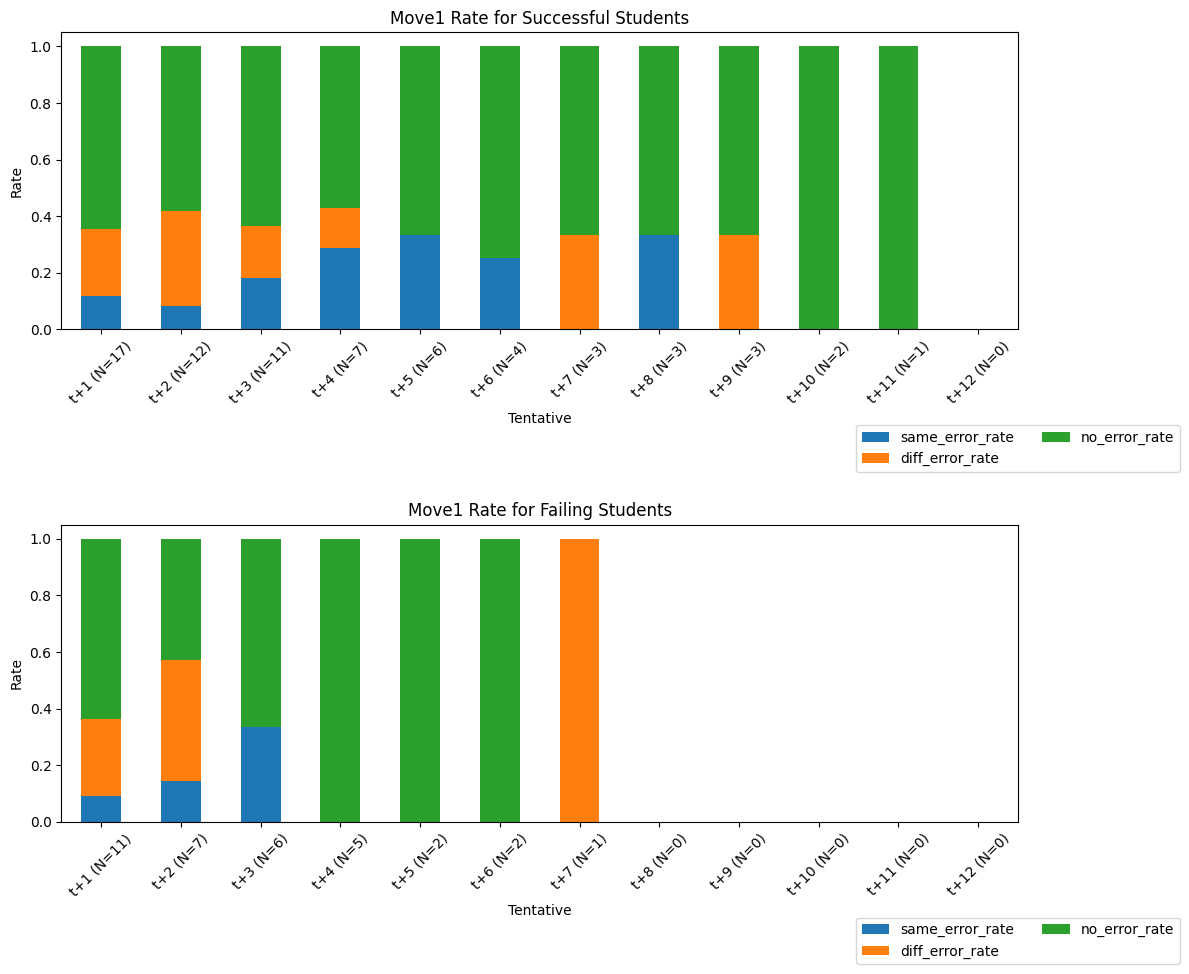

In [999]:
generate_same_diff_type_error_plot(data_move1, 'Move1')

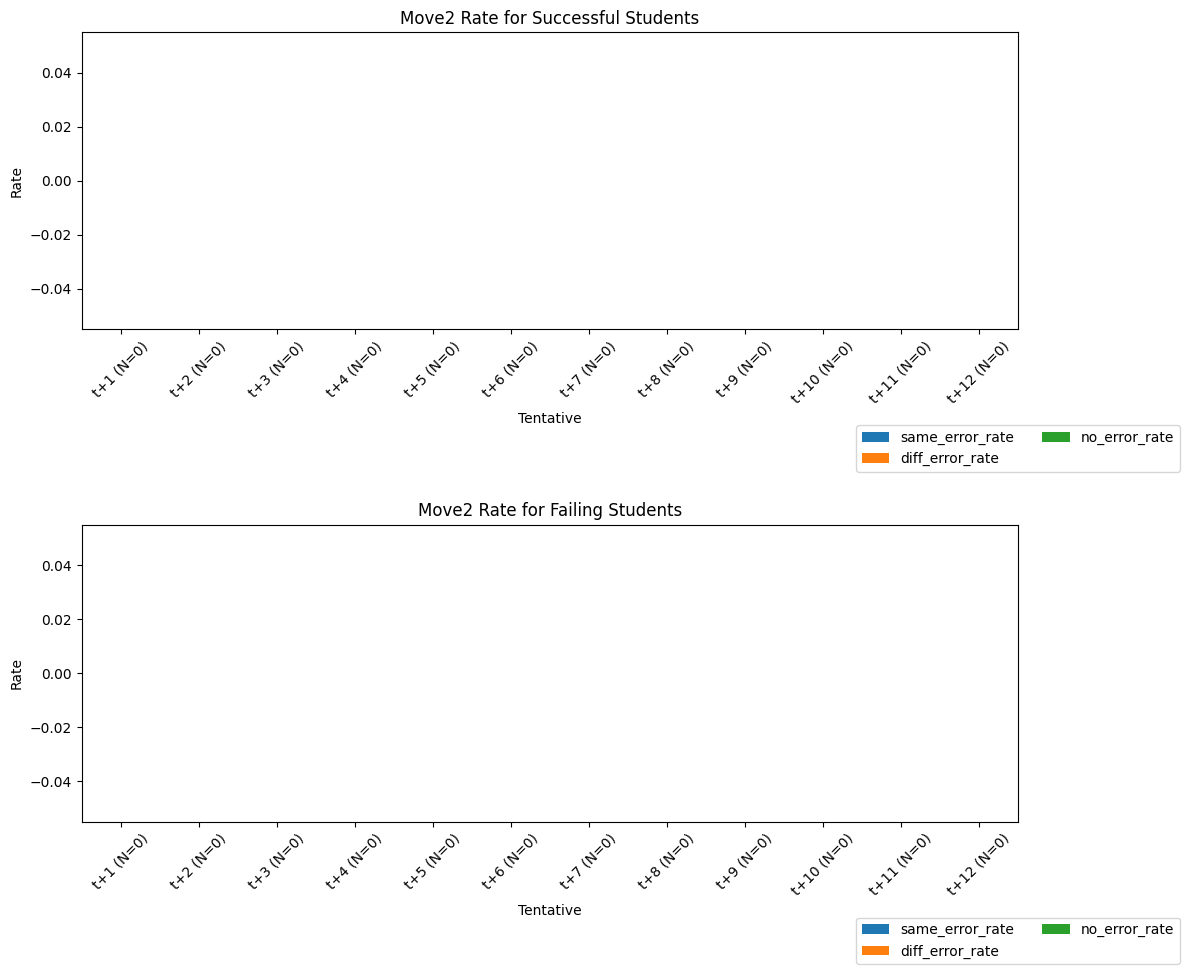

In [1000]:
generate_same_diff_type_error_plot(data_move2, 'Move2')

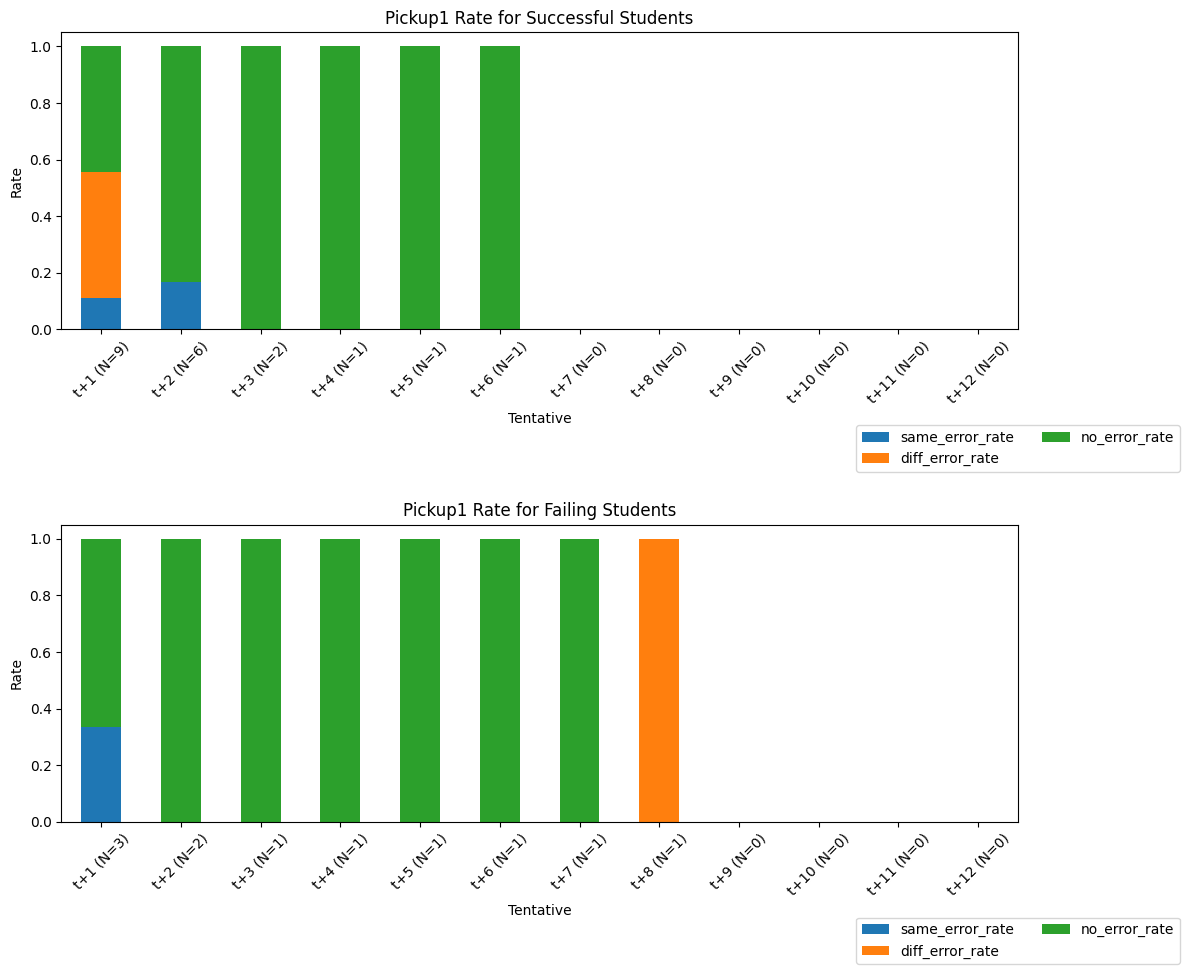

In [1001]:
generate_same_diff_type_error_plot(data_pickup1, 'Pickup1')

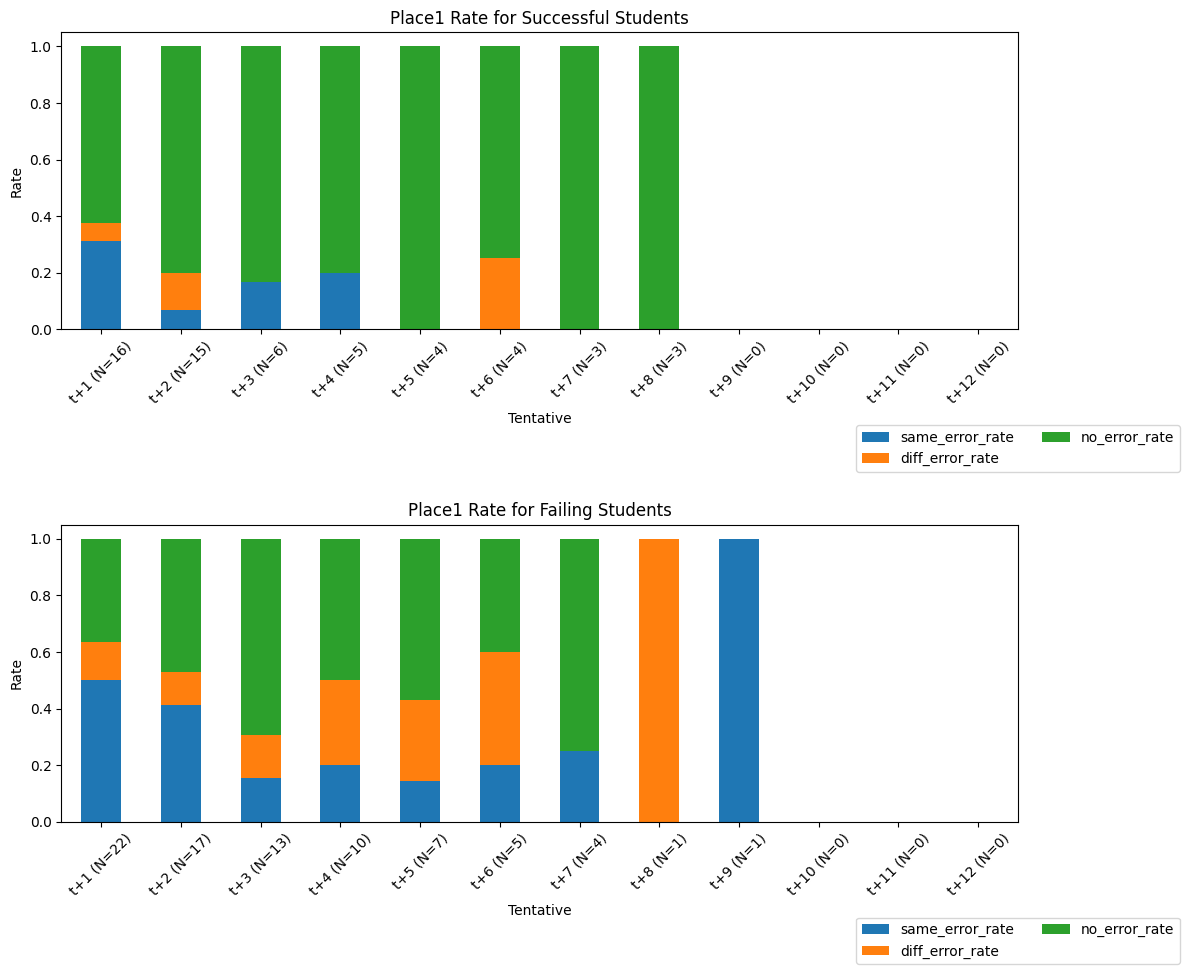

In [1002]:
generate_same_diff_type_error_plot(data_place1, 'Place1')

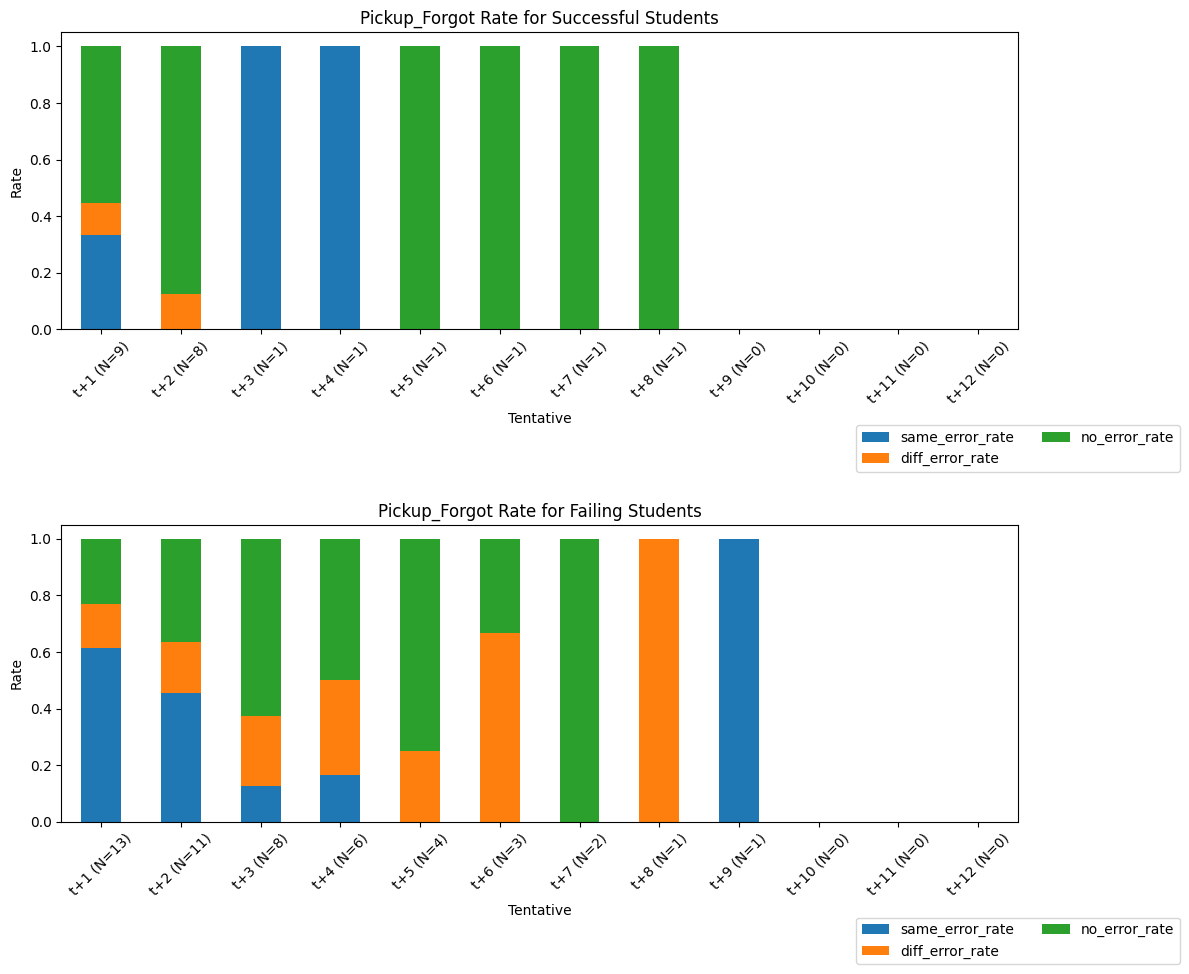

In [1003]:
generate_same_diff_type_error_plot(data_pickup_forgot, 'Pickup_Forgot')

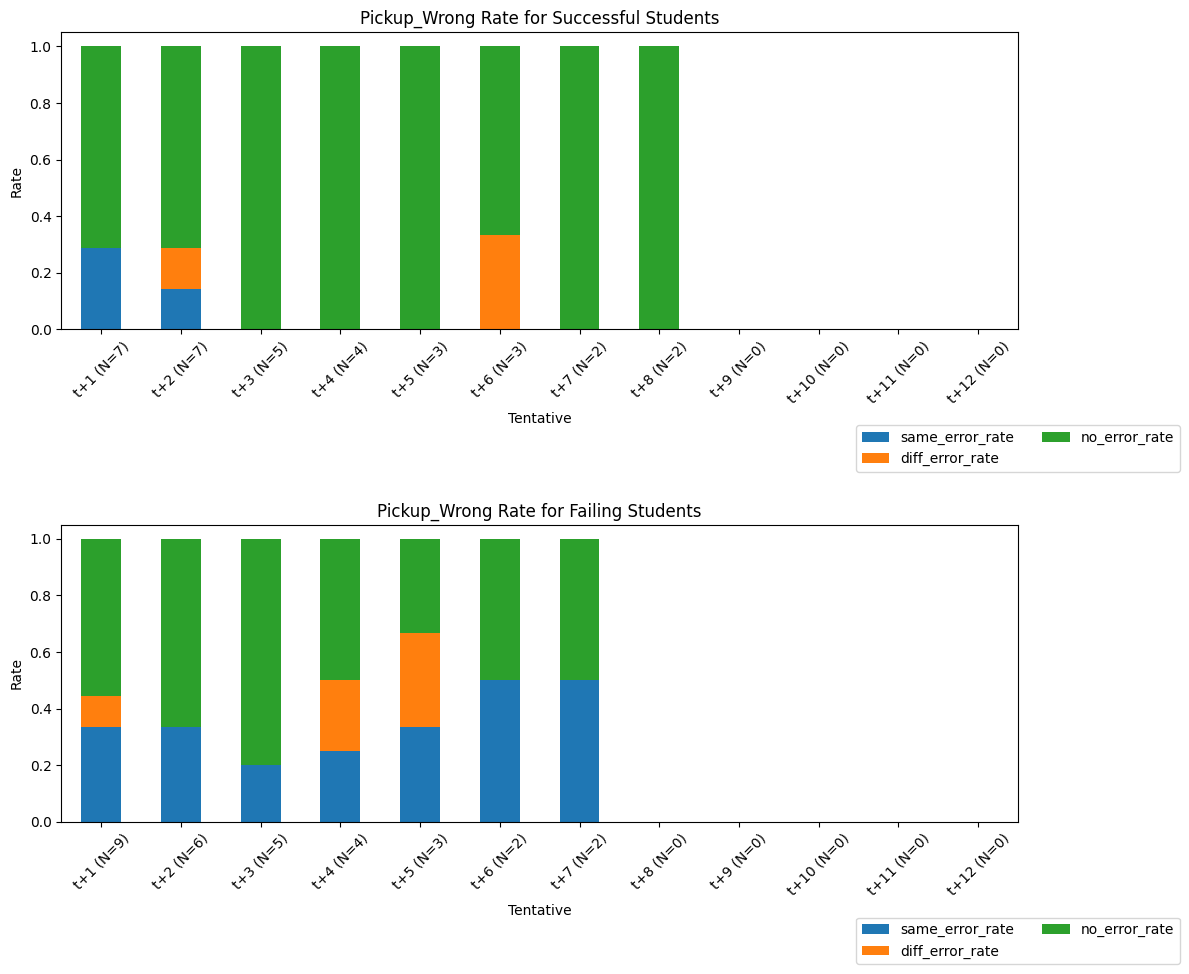

In [1004]:
generate_same_diff_type_error_plot(data_pickup_wrong, 'Pickup_Wrong')

Let's analysis it per tentatives 

In [1005]:
def generate_data_diff_same_error(data, tentative): 
    print(f"Generate data for {tentative} tentatives")
    data_error_same_diff_tentatives = []

    for i in range(1, tentative):
        data_error_same_diff_tentatives.append(data.groupby('Student ID').nth(i))
        
    data_same_diff_success = []
    data_same_diff_fail = []

    for df in data_error_same_diff_tentatives:
        df_success = df[df['success'] == 1]
        
        same_error_rate = df_success['same_error'].mean()
        diff_error_rate = df_success['diff_error'].mean()
        no_error_rate = df_success['no_error'].mean()
        
        data_same_diff_success.append({'same_error_rate': same_error_rate, 'diff_error_rate': diff_error_rate, 
                                        'no_error_rate': no_error_rate, 'count': len(df_success), 'nb_tentatives': tentative, 'success': 1})
        
        df_fail = df[df['success'] == 0]
        
        same_error_rate = df_fail['same_error'].mean()
        diff_error_rate = df_fail['diff_error'].mean()
        no_error_rate = df_fail['no_error'].mean()
        
        data_same_diff_fail.append({'same_error_rate': same_error_rate, 'diff_error_rate': diff_error_rate, 
                                        'no_error_rate': no_error_rate, 'count': len(df_fail), 'nb_tentatives': tentative, 'success': 0})
        
    data_same_diff_success = pd.DataFrame(data_same_diff_success)
    data_same_diff_fail = pd.DataFrame(data_same_diff_fail)

    # add column tentatives to the data_error_rate_success and data_error_rate_fail
    data_same_diff_success['tentatives'] = [f"t+{i}" for i in range(1, tentative)]
    data_same_diff_fail['tentatives'] = [f"t+{i}" for i in range(1, tentative)]

    tentatives_success = [f"{tentative} (N={count})" for tentative, count in zip(data_same_diff_success['tentatives'], data_same_diff_success['count'])]
    tentatives_fail = [f"{tentative} (N={count})" for tentative, count in zip(data_same_diff_fail['tentatives'], data_same_diff_fail['count'])]

    data_same_diff_success['tentatives'] = tentatives_success
    data_same_diff_fail['tentatives'] = tentatives_fail
    
    data_same_diff = pd.concat([data_same_diff_success, data_same_diff_fail])
    
    return data_same_diff

In [1006]:
data_error_same_diff_filtered = data_error_same_diff[data_error_same_diff['nb_tentative'] <= 12]

data_tentatives_same_diff = []

for i in range(2, data_error_same_diff_filtered['nb_tentative'].max()+1):
    df = data_error_same_diff_filtered[data_error_same_diff_filtered['nb_tentative'] == i]
    print(len(df))
    data_tentatives_same_diff.append(generate_data_diff_same_error(df, i))


8
Generate data for 2 tentatives
32
Generate data for 3 tentatives
37
Generate data for 4 tentatives
47
Generate data for 5 tentatives
36
Generate data for 6 tentatives
28
Generate data for 7 tentatives
37
Generate data for 8 tentatives
23
Generate data for 9 tentatives
18
Generate data for 10 tentatives
46
Generate data for 11 tentatives
20
Generate data for 12 tentatives


In [1007]:
# concat the data
data_tentatives_same_diff = pd.concat(data_tentatives_same_diff)

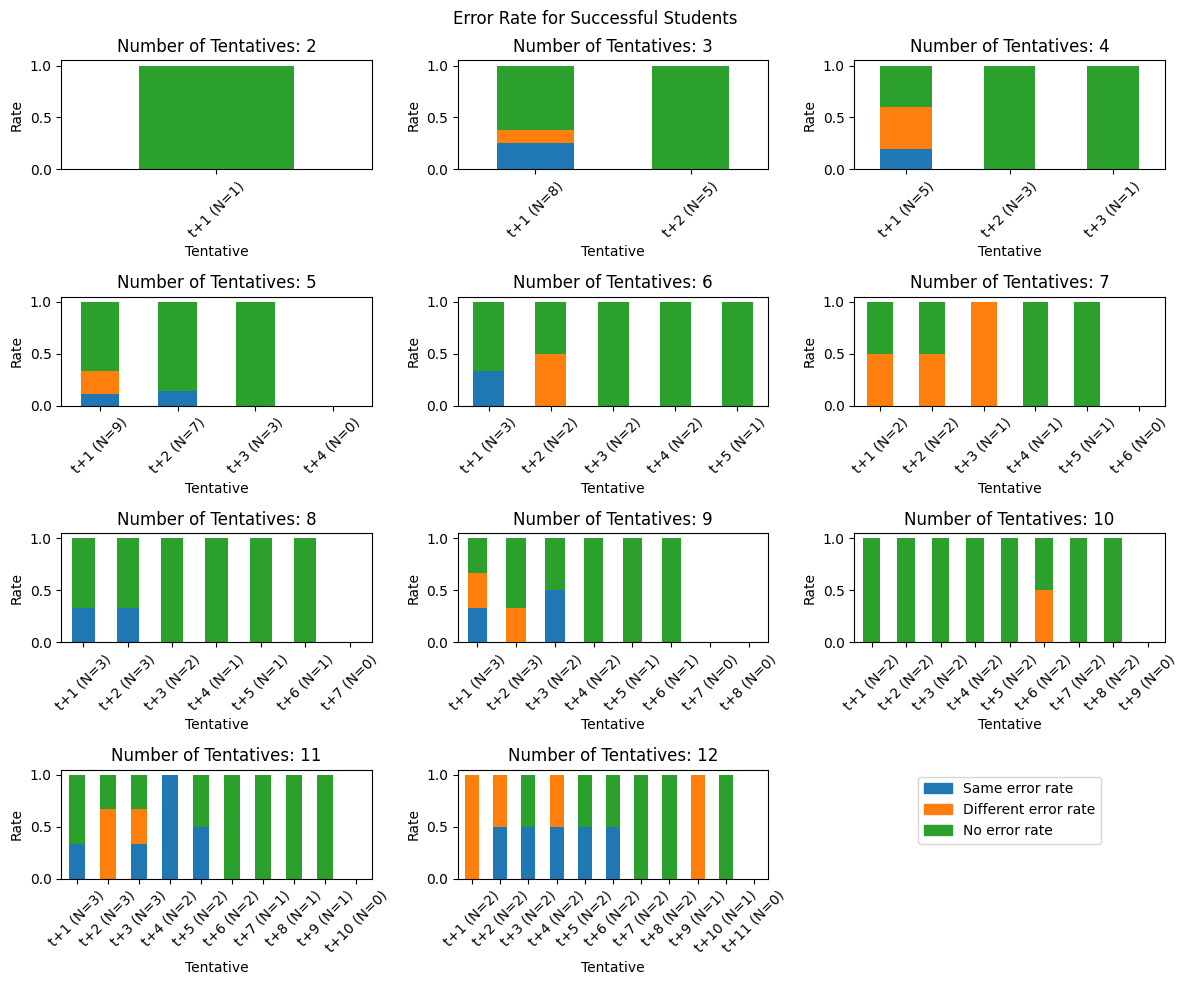

In [1008]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

# Define the colors for the legend
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, ax in enumerate(axs.flat):
    if i < len(data_tentatives_same_diff['nb_tentatives'].unique()):
        df = data_tentatives_same_diff[data_tentatives_same_diff['nb_tentatives'] == i+2]
        df_success = df[df['success'] == 1]
        
        bars = df_success[['same_error_rate', 'diff_error_rate', 'no_error_rate', 'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), x='tentatives', legend=False, ax=ax)
        ax.set_title(f"Number of Tentatives: {i+2}")
        ax.set_xlabel('Tentative')
        ax.set_ylabel('Rate')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    else:
        ax.axis('off')
    
legend_patches = [mpatches.Patch(color='tab:blue', label='Same error rate'), mpatches.Patch(color='tab:orange', label='Different error rate'), mpatches.Patch(color='tab:green', label='No error rate')] 
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1), fancybox=True, ncol=1)
plt.suptitle('Error Rate for Successful Students')
plt.tight_layout()
plt.savefig(f"{folder}/error_rate_same_diff_success_multi.png")
plt.show()


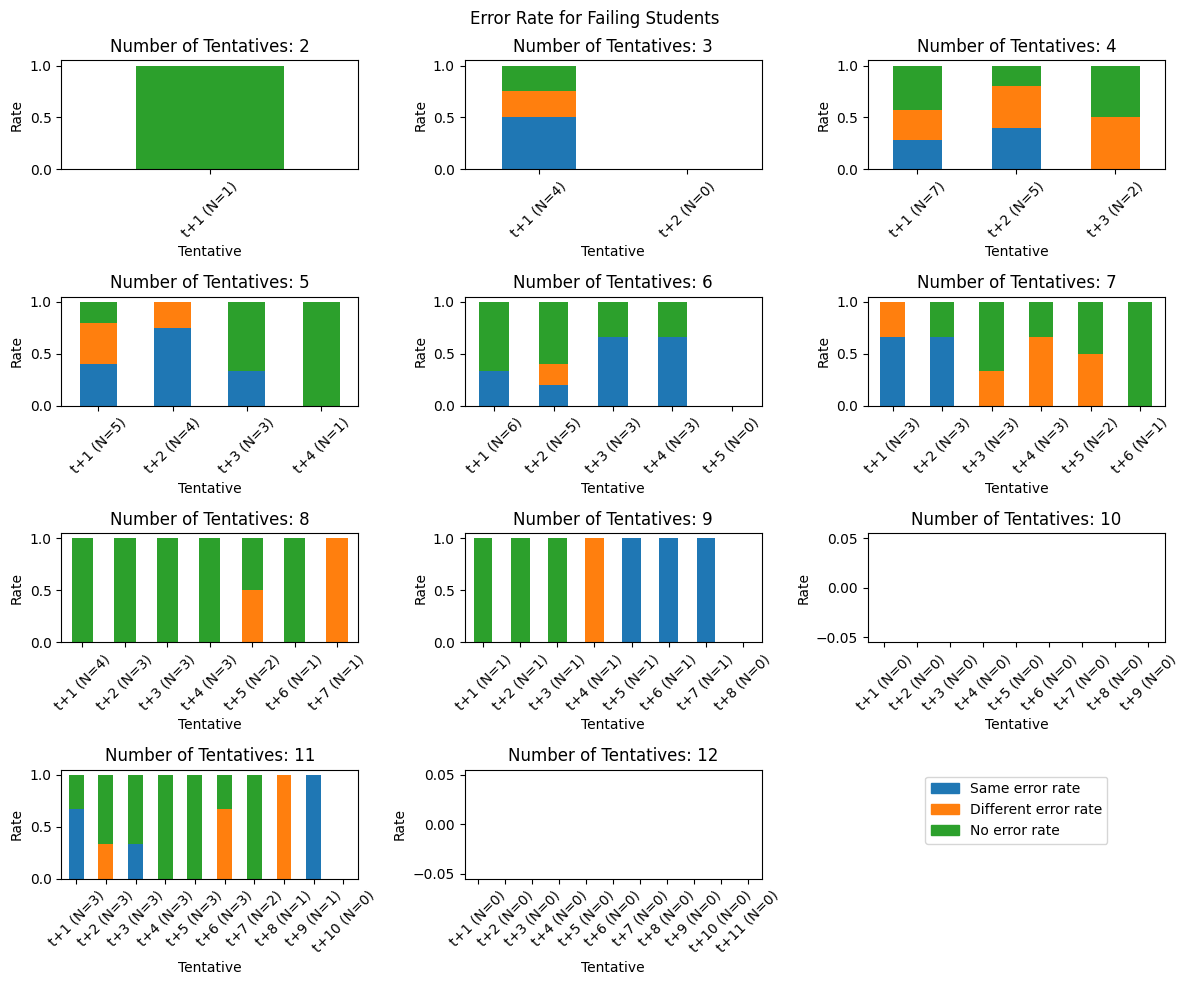

In [1009]:
fig, axs = plt.subplots(4, 3, figsize=(15, 12))

# Define the colors for the legend
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, ax in enumerate(axs.flat):
    if i < len(data_tentatives_same_diff['nb_tentatives'].unique()):
        df = data_tentatives_same_diff[data_tentatives_same_diff['nb_tentatives'] == i+2]
        df_fail = df[df['success'] == 0]
        
        if len(df_fail) > 0:
            
            bars = df_fail[['same_error_rate', 'diff_error_rate', 'no_error_rate', 'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), x='tentatives', legend=False, ax=ax)
            ax.set_title(f"Number of Tentatives: {i+2}")
            ax.set_xlabel('Tentative')
            ax.set_ylabel('Rate')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    else:
        ax.axis('off')
    
legend_patches = [mpatches.Patch(color='tab:blue', label='Same error rate'), mpatches.Patch(color='tab:orange', label='Different error rate'), mpatches.Patch(color='tab:green', label='No error rate')] 
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1), fancybox=True, ncol=1)
plt.suptitle('Error Rate for Failing Students')
plt.tight_layout()
plt.savefig(f"{folder}/error_rate_same_diff_fail_multi.png")
plt.show()


In [1010]:
def generate_fail_same_diff_type_error_bar_plot_per_tentative(data, error): 
    
    data_filtered = data[data['nb_tentative'] <= 12]

    data_tentatives_same_diff = []

    for i in range(2, data_filtered['nb_tentative'].max()+1):
        df = data_filtered[data_filtered['nb_tentative'] == i]
        print(len(df))
        data_tentatives_same_diff.append(generate_data_diff_same_error(df, i))
    
    data_tentatives_same_diff = pd.concat(data_tentatives_same_diff)
    
    fig, axs = plt.subplots(4, 3, figsize=(15, 12))

    for i, ax in enumerate(axs.flat):
        if i < len(data_tentatives_same_diff['nb_tentatives'].unique()):
            df = data_tentatives_same_diff[data_tentatives_same_diff['nb_tentatives'] == i+2]
            
            df_fail = df[df['success'] == 0]
                
            df_fail[['same_error_rate', 'diff_error_rate', 'no_error_rate', 'tentatives']].plot(kind='bar', stacked=True, figsize=(12, 10), x='tentatives', legend=False, ax=ax)
            ax.set_title(f"Number of Tentatives: {i+2}")
            ax.set_xlabel('Tentative')
            ax.set_ylabel('Rate')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            
        else:
            ax.axis('off')
        
    legend_patches = [mpatches.Patch(color='tab:blue', label='Same error rate'), mpatches.Patch(color='tab:orange', label='Different error rate'), mpatches.Patch(color='tab:green', label='No error rate')] 
    plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1), fancybox=True, ncol=1)
    plt.suptitle(f'{error} Rate for Failing Students')
    plt.tight_layout()
    plt.show()

Let's analyse now the CASES

* CASE 1: Error with missing element
* CASE 2: Error with non missing element
* CASE 3: No error but missing element

* Observe general distribution of those cases 
* Same plot as above 
* Plot of mean and CI per index of thoses cases (time series plots)
* make time series plot of move1, move2, place1, pickup1
* How to analyse it in 2 dimensions ? 

Another interesting analysis is : how much does each error impact on the euclidean distance

In [1011]:
for idx, row in data.iterrows():
    if row['error'] == 1 and row['missing'] == 1: 
        data.loc[idx, 'case1'] = 1
        data.loc[idx, 'case2'] = 0
        data.loc[idx, 'case3'] = 0
    elif row['error'] == 1 and row['missing'] == 0:
        data.loc[idx, 'case1'] = 0
        data.loc[idx, 'case2'] = 1
        data.loc[idx, 'case3'] = 0
    elif row['error'] == 0 and row['missing'] == 1:
        data.loc[idx, 'case1'] = 0
        data.loc[idx, 'case2'] = 0
        data.loc[idx, 'case3'] = 1
    else: 
        data.loc[idx, 'case1'] = 0
        data.loc[idx, 'case2'] = 0
        data.loc[idx, 'case3'] = 0

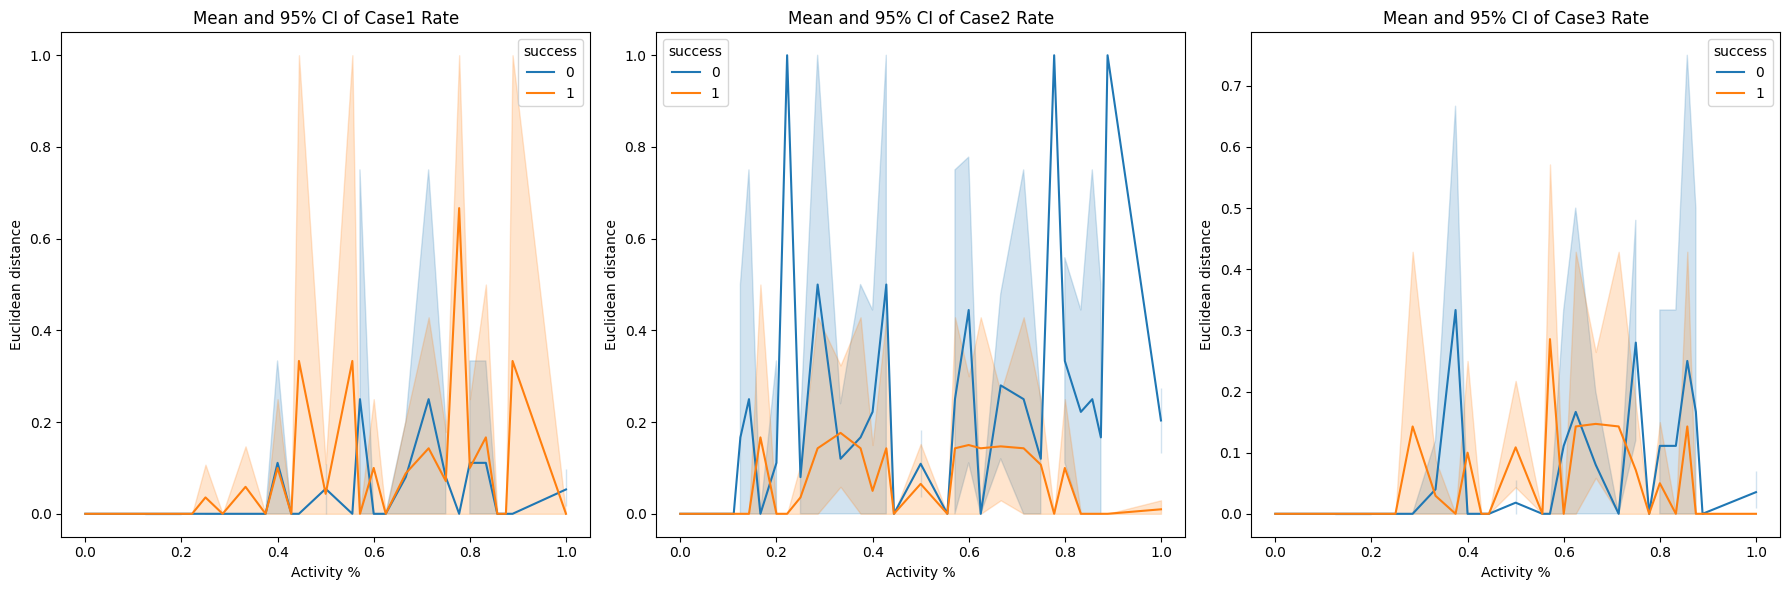

In [1012]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

data_filtered = data[data['nb_tentative'] <= 9]

# Plot for case1
sns.lineplot(data=data_filtered, y='case1', x='pct_activity', hue="success",
             err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[0])
axs[0].set_xlabel('Activity %')
axs[0].set_ylabel('Euclidean distance')
axs[0].set_title('Mean and 95% CI of Case1 Rate')

# Plot for case2
sns.lineplot(data=data_filtered, y='case2', x='pct_activity', hue="success",
             err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[1])
axs[1].set_xlabel('Activity %')
axs[1].set_ylabel('Euclidean distance')
axs[1].set_title('Mean and 95% CI of Case2 Rate')

# Plot for case3
sns.lineplot(data=data_filtered, y='case3', x='pct_activity', hue="success",
             err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=axs[2])
axs[2].set_xlabel('Activity %')
axs[2].set_ylabel('Euclidean distance')
axs[2].set_title('Mean and 95% CI of Case3 Rate')

plt.tight_layout()
plt.savefig(f"{folder}/cases_rate_pct.png")
plt.show()

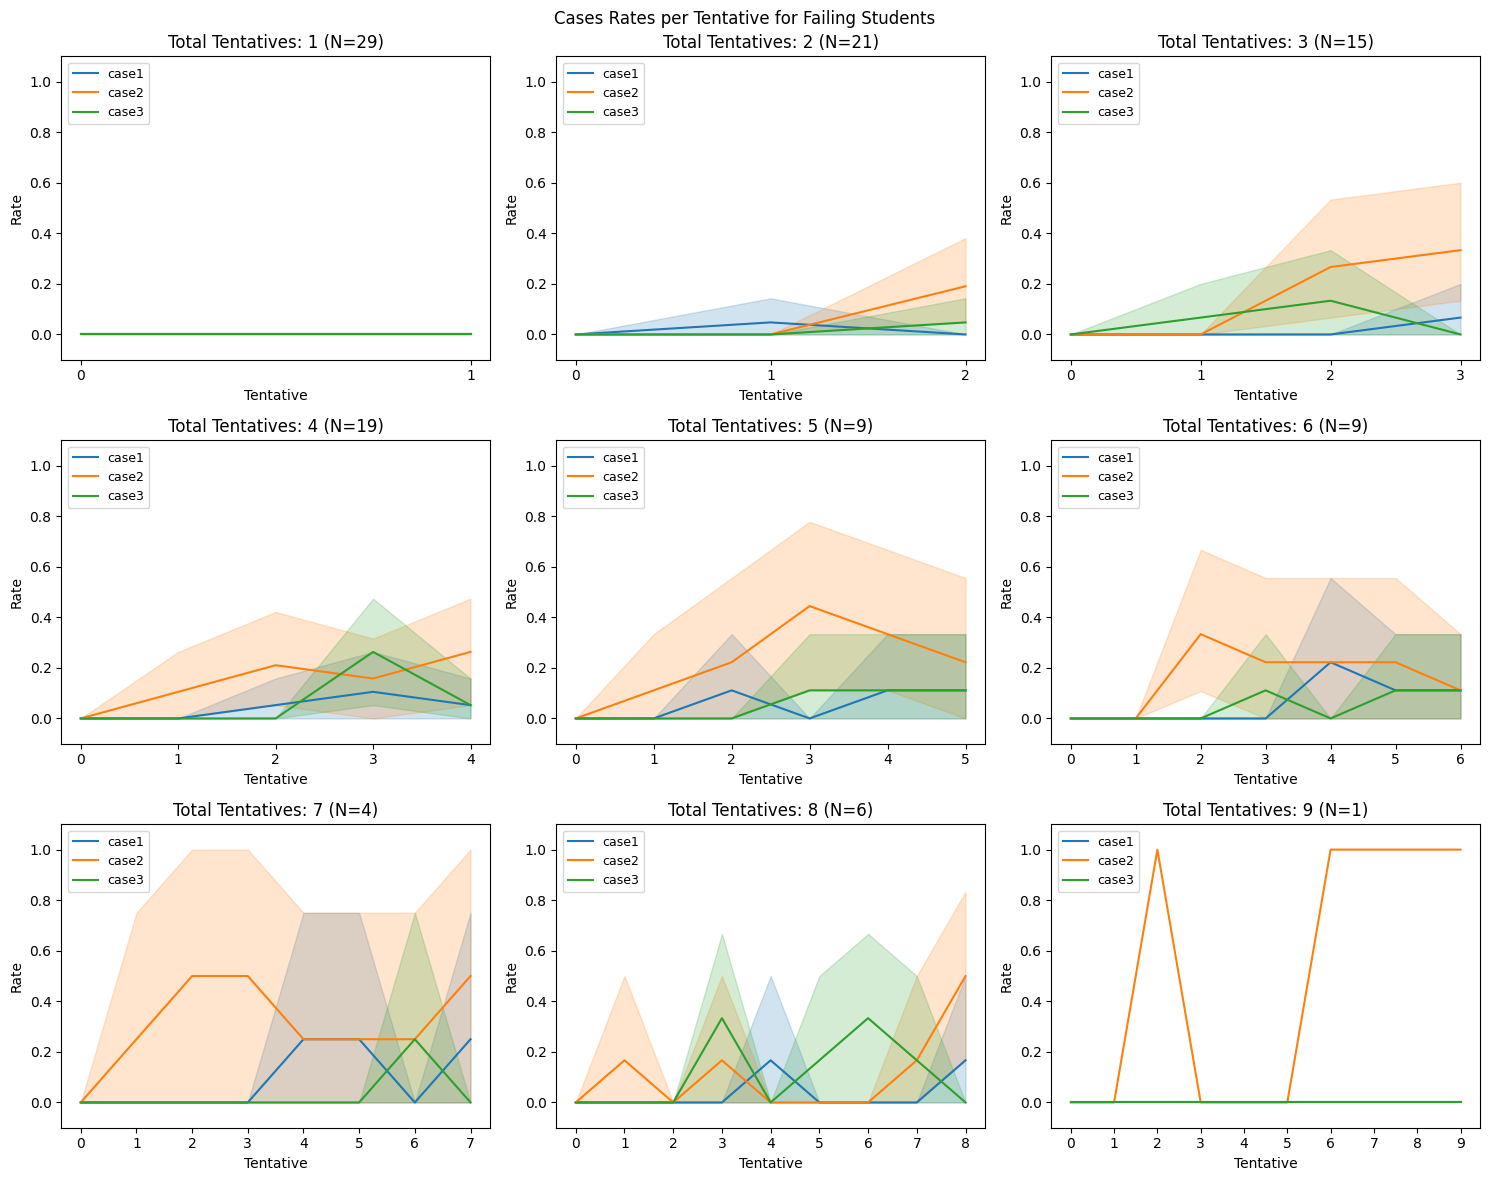

In [1013]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axs = plt.subplots(3, 3, figsize=(15, 12))

data_fail = data[data.success == 0]

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        data_fail_tentative = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]

        nb_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        
        for column in ['case1', 'case2', 'case3']:
            sns.lineplot(data=data_fail_tentative, y=column, x='index', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax, label=column)


        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]} (N={nb_student})")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Cases Rates per Tentative for Failing Students')
plt.tight_layout()
plt.savefig(f'{folder}/cases_rate_fail_multi.png')

plt.show()

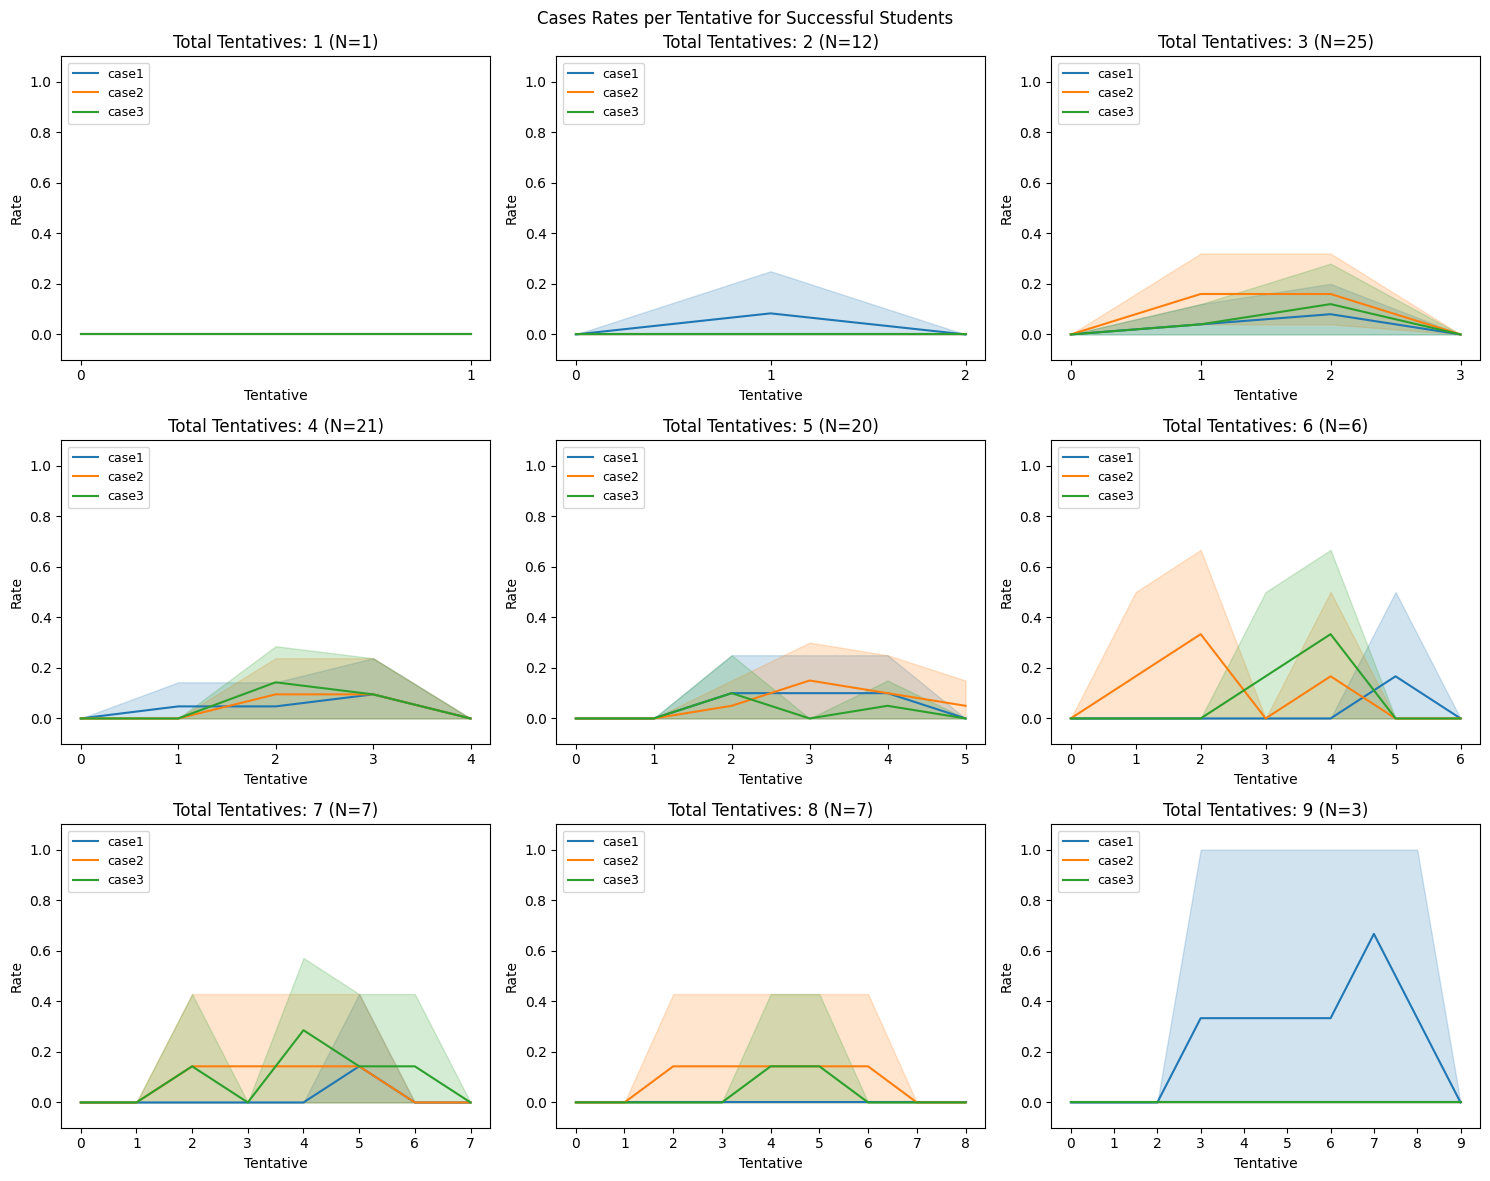

In [1014]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axs = plt.subplots(3, 3, figsize=(15, 12))

data_success = data[data.success == 1]

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        data_success_tentative = data_success[data_success['nb_tentative'] == tot_tentatives[i]]

        nb_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        
        for column in ['case1', 'case2', 'case3']:
            sns.lineplot(data=data_success_tentative, y=column, x='index', 
                         err_style="band", errorbar='ci', estimator=np.mean, ci=95, ax=ax, label=column)


        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]} (N={nb_student})")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Cases Rates per Tentative for Successful Students')
plt.tight_layout()
plt.savefig(f'{folder}/cases_rate_success_multi.png')

plt.show()

* Some students are still stuck in errors 
* 